# Use TROPESS CRIS-JPSS1 Los Angeles Megacity Data 
# to Study Trace Gases Emitted from LA Fires in January, 2025.

## Overview
This notebook will allow you to download [TROPESS](https://tes.jpl.nasa.gov/tropess) CRIS-JPSS1 Los Angeles Megacity data collection (shortname: TRPSDL2ALLCRS1MGLOS.2) and then use the data to plot and characterize the outflows of trace gases from the LA fires in January 2025.  

## Requirements

This notebook uses the [GES-DISC's](https://disc.gsfc.nasa.gov) simple subset service to retrieve requested data.  It requires a [NASA Earthdata login](https://urs.earthdata.nasa.gov/).  Please make sure you have one before attempting to run this notebook.  And make sure you've setup a `.netrc` and `.urs_cookies` file in your home directory with your NASA Earthata login information.  You can use the follow steps to generate the files, if needed:

```sh
cd ~
touch .netrc
echo "machine urs.earthdata.nasa.gov login uid_goes_here password password_goes_here" > .netrc
chmod 0600 .netrc
touch .urs_cookies
```

This notebook uses several libraries (see the cell below). Please make sure these libraries are installed. You can use the command (!pip install library_name) for installation. For example:

```python
!pip install datetime
```


## Import Libraries

In [19]:
import datetime as dt
import contextlib
import os

from pathlib import Path

import pandas as pd

import numpy as np
from netCDF4 import Dataset

import xarray as xr

import matplotlib.pyplot as plt

import imageio.v2 as imageio

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

from scipy.interpolate import griddata
from scipy.spatial import cKDTree

import matplotlib.patheffects as pe

from metpy.plots import USCOUNTIES

import requests
import glob

from IPython.display import display, HTML
display(HTML("<style>div.output_scroll { height: auto; overflow: visible; }</style>"))

## Define a function to generate a plot from the TROPESS CRIS-JPSS-1 Megacity Los Angeles Data. 

In [8]:
def plot_data_map(latitudes, longitudes, this_data, this_data_min, this_data_max, this_data_label, this_plot_title, output_filename):
    """
    Generates a map plot of XCO data.

    Args:
        latitudes (numpy.ndarray): Array of latitude values.
        longitudes (numpy.ndarray): Array of longitude values.
        this_data (numpy.ndarray): Array of data values.
        this_data_min (float): minimum value of the data in color bar
        this_data_max (float): maximum value of the data in color bar
        this_data_label (str): the label of the data. 
        this_plot_title (str): the title of plot.
        output_filename (str): The filename to save the output plot.
    """
    # Calculate width and height for the desired axes size
    longitude_max = -117
    longitude_min = -119 - 0.4
    latitude_max = 35 + 0.2
    latitude_min = 33 - 0.2
    aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)

    # Choose a figure size. This will be the overall size of the image.
    # You might need to adjust this based on how much space you need for labels, colorbar, etc.
    fig_width_inches = 6
    fig_height_inches = fig_width_inches / aspect_ratio * 1.2 # Add some space for labels and colorbar

    dpi = 300;
    fig = plt.figure(figsize=(fig_width_inches, fig_height_inches), dpi=dpi)

    # Define the position and size of the axes within the figure [left, bottom, width, height]
    # These values are in fractions of the figure width and height (0 to 1)
    # Adjust these values to make space for labels, title, and colorbar
    ax_left = 0.1
    ax_bottom = 0.05
    ax_height = 0.75
    ax_width = ax_height * aspect_ratio

    #print(f"aspect ratio: {aspect_ratio}")

    ax = fig.add_axes([ax_left, ax_bottom, ax_width, ax_height], projection=ccrs.PlateCarree())
    # Increase coastline linewidth for better visibility
    ax.coastlines(resolution='10m', linewidth=1.0, color='black')

    # Calculate s_value for scatter plot (copying relevant calculations from previous successful cell)
    ax_width_inches = ax_width * fig_width_inches
    ax_height_inches = ax_height * fig_height_inches
    dot_size_km = 7 # km in radius; CRIS footprint size is about 14 km diameter
    ax_width_km = (longitude_max - longitude_min)*92.24 # based on latitude  34.
    scale_from_km_to_inch = ax_width_inches/ax_width_km
    dot_size_inches = dot_size_km * scale_from_km_to_inch
    dot_size_points = dot_size_inches * 72
    s_value = np.pi * (dot_size_points)**2

    min_val = min(this_data)
    max_val = max(this_data)
    print(f"min value: {min_val}, max value: {max_val}")


    cb = ax.scatter(longitudes, latitudes, c=this_data, s=s_value, cmap=plt.colormaps["jet"],
                    vmin=this_data_min, vmax=this_data_max,
                    transform=ccrs.PlateCarree())

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.0, color='k',alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    # Set the gridline ticks to include the extent limits
    #gl.xlocator = plt.FixedLocator([longitude_min, (longitude_min + longitude_max) / 2, longitude_max])
    #gl.ylocator = plt.FixedLocator([latitude_min, (latitude_min + latitude_max) / 2, latitude_max])

    ax.set_extent([longitude_min,longitude_max,latitude_min,latitude_max])

    # Add a colorbar. You might need to adjust its position as well.
    cbar_ax = fig.add_axes([ax_left, ax_bottom - 0.08, ax_width, 0.03]) # [left, bottom, width, height] for the colorbar
    fig.colorbar(cb, cax=cbar_ax, label=this_data_label, orientation="horizontal")


    # Define coordinates and names for major cities
    # Slightly adjust positions to avoid direct overlap with data points if necessary
    city_lats = [34.0522, 33.7701, 33.7455, 34.1477, 34.0381, 33.9825, 34.2808, 34.7039, 34.1046]
    city_lons = [-118.2437, -118.1937, -117.8677, -118.1443, -118.6923, -117.3758, -119.2931, -118.1481, -117.2919]
    city_names = ['Los Angeles', 'Long Beach', 'Santa Ana', 'Pasadena', 'Malibu', 'Riverside', 'Ventura', 'Lancaster', 'San Bernadino']

    # Add city names to the map with adjusted properties for better visibility
    for lat, lon, name in zip(city_lats, city_lons, city_names):
        ax.text(lon, lat, name,
                color='black', # Use black color for contrast against the colored data points
                fontsize=10, # Adjust fontsize as needed
                #fontweight='bold',
                ha='center',
                va='bottom',
                transform=ccrs.PlateCarree()
        )


    # Add county lines at a specific scale
    ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='black', linewidth=0.5)


    # Add a title to the plot
    plt.suptitle(this_plot_title, y=0.85, fontsize=14) # Adjust y for positioning and set fontsize

    # Save figure to PNG file
    # Make sure the 'images' directory exists
    os.makedirs('./images', exist_ok=True)
    plt.savefig(output_filename, dpi=dpi, bbox_inches='tight')
    plt.show()
    plt.close()

## Filter the data based on data quality conditions

In [9]:
def filter_good_col_data(ds, ds_aux, species):
    """
    Filters good data points based on quality flags.

    Args:
        ds (xarray.Dataset): The main dataset.
        ds_aux (xarray.Dataset): The auxiliary dataset with data quality conditions.

    Returns:
        tuple: A tuple containing:
            - latitudes (numpy.ndarray): Filtered latitude values.
            - longitudes (numpy.ndarray): Filtered longitude values.
            - this_data (numpy.ndarray): Filtered data values.
    """
    
    # Select day data and choose cloud effective optical depth smaller than 0.5
    good_data_mask = (ds_aux.day_night_flag == 1) & (ds_aux.average_cloud_eod <0.5)

    latitudes = ds.latitude[good_data_mask].values
    longitudes = ds.longitude[good_data_mask].values
    this_data = []
    if (species == 'CO'):
      this_data = ds.col[good_data_mask].values #  Vertically integrated total column in mol m-2  
    if (species == 'PAN'):
      this_data = ds.x_col_ft[good_data_mask].values #  Column-averaged dry air mixing ratio of PAN for the free troposphere column between 825 and 215 hPa
    if (species == 'NH3'):
      this_data = ds.x[good_data_mask,1].values # Volume mixing ratio of NH3 relative to dry 
      this_data = this_data*1.0e9 # ppbv (parts per billion by volume)
      #print("pressure level 1 =", ds.pressure[0,1].values)
    
    return latitudes, longitudes, this_data

In [10]:
# Where you want to store the data you download.
DOWNLOAD_DIRECTORY = './download'

# Where you want to store the plot outputs.
PLOT_DIRECTORY = './plot'

# Create directories if they don't already exist
os.makedirs(DOWNLOAD_DIRECTORY, exist_ok=True)
os.makedirs(PLOT_DIRECTORY, exist_ok=True)

## Prepare a file that has the list of URLs for data downloads.

In [11]:
urls = """
https://data.gesdisc.earthdata.nasa.gov/data/TROPESS_MegaCities_Standard/TRPSDL2ALLCRS1MGLOS.2/2025/01/07/TROPESS_CrIS-JPSS1_L2_Standard_CO_20250107_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc
https://data.gesdisc.earthdata.nasa.gov/data/TROPESS_MegaCities_Standard/TRPSDL2ALLCRS1MGLOS.2/2025/01/07/TROPESS_CrIS-JPSS1_L2_Standard_NH3_20250107_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc
https://data.gesdisc.earthdata.nasa.gov/data/TROPESS_MegaCities_Standard/TRPSDL2ALLCRS1MGLOS.2/2025/01/07/TROPESS_CrIS-JPSS1_L2_Standard_PAN_20250107_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc
https://data.gesdisc.earthdata.nasa.gov/data/TROPESS_MegaCities_Standard/TRPSDL2ALLCRS1MGLOS.2/2025/01/08/TROPESS_CrIS-JPSS1_L2_Standard_CO_20250108_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc
https://data.gesdisc.earthdata.nasa.gov/data/TROPESS_MegaCities_Standard/TRPSDL2ALLCRS1MGLOS.2/2025/01/08/TROPESS_CrIS-JPSS1_L2_Standard_NH3_20250108_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc
https://data.gesdisc.earthdata.nasa.gov/data/TROPESS_MegaCities_Standard/TRPSDL2ALLCRS1MGLOS.2/2025/01/08/TROPESS_CrIS-JPSS1_L2_Standard_PAN_20250108_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc
https://data.gesdisc.earthdata.nasa.gov/data/TROPESS_MegaCities_Standard/TRPSDL2ALLCRS1MGLOS.2/2025/01/09/TROPESS_CrIS-JPSS1_L2_Standard_CO_20250109_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc
https://data.gesdisc.earthdata.nasa.gov/data/TROPESS_MegaCities_Standard/TRPSDL2ALLCRS1MGLOS.2/2025/01/09/TROPESS_CrIS-JPSS1_L2_Standard_NH3_20250109_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc
https://data.gesdisc.earthdata.nasa.gov/data/TROPESS_MegaCities_Standard/TRPSDL2ALLCRS1MGLOS.2/2025/01/09/TROPESS_CrIS-JPSS1_L2_Standard_PAN_20250109_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc
https://data.gesdisc.earthdata.nasa.gov/data/TROPESS_MegaCities_Standard/TRPSDL2ALLCRS1MGLOS.2/2025/01/10/TROPESS_CrIS-JPSS1_L2_Standard_CO_20250110_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc
https://data.gesdisc.earthdata.nasa.gov/data/TROPESS_MegaCities_Standard/TRPSDL2ALLCRS1MGLOS.2/2025/01/10/TROPESS_CrIS-JPSS1_L2_Standard_NH3_20250110_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc
https://data.gesdisc.earthdata.nasa.gov/data/TROPESS_MegaCities_Standard/TRPSDL2ALLCRS1MGLOS.2/2025/01/10/TROPESS_CrIS-JPSS1_L2_Standard_PAN_20250110_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc
"""

with open('URL_list.txt', 'w') as f:
    f.write(urls.strip())

In [12]:
# Download data with wget command

!wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies -P ./download -nc -i URL_list.txt 

File './download/TROPESS_CrIS-JPSS1_L2_Standard_CO_20250107_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc' already there; not retrieving.

File './download/TROPESS_CrIS-JPSS1_L2_Standard_NH3_20250107_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc' already there; not retrieving.

File './download/TROPESS_CrIS-JPSS1_L2_Standard_PAN_20250107_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc' already there; not retrieving.

File './download/TROPESS_CrIS-JPSS1_L2_Standard_CO_20250108_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc' already there; not retrieving.

File './download/TROPESS_CrIS-JPSS1_L2_Standard_NH3_20250108_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc' already there; not retrieving.

File './download/TROPESS_CrIS-JPSS1_L2_Standard_PAN_20250108_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc' already there; not retrieving.

File './download/TROPESS_CrIS-JPSS1_L2_Standard_CO_20250109_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc' already there; not retrieving.

File './download/TROPESS_CrIS-JPSS1_L2_Standard_NH3_20250109_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc' already there; not retrievi

## Plot CO column values for each day from January 7 to January 10, 2025.

min value: 0.023240776732563972, max value: 0.040371123701334


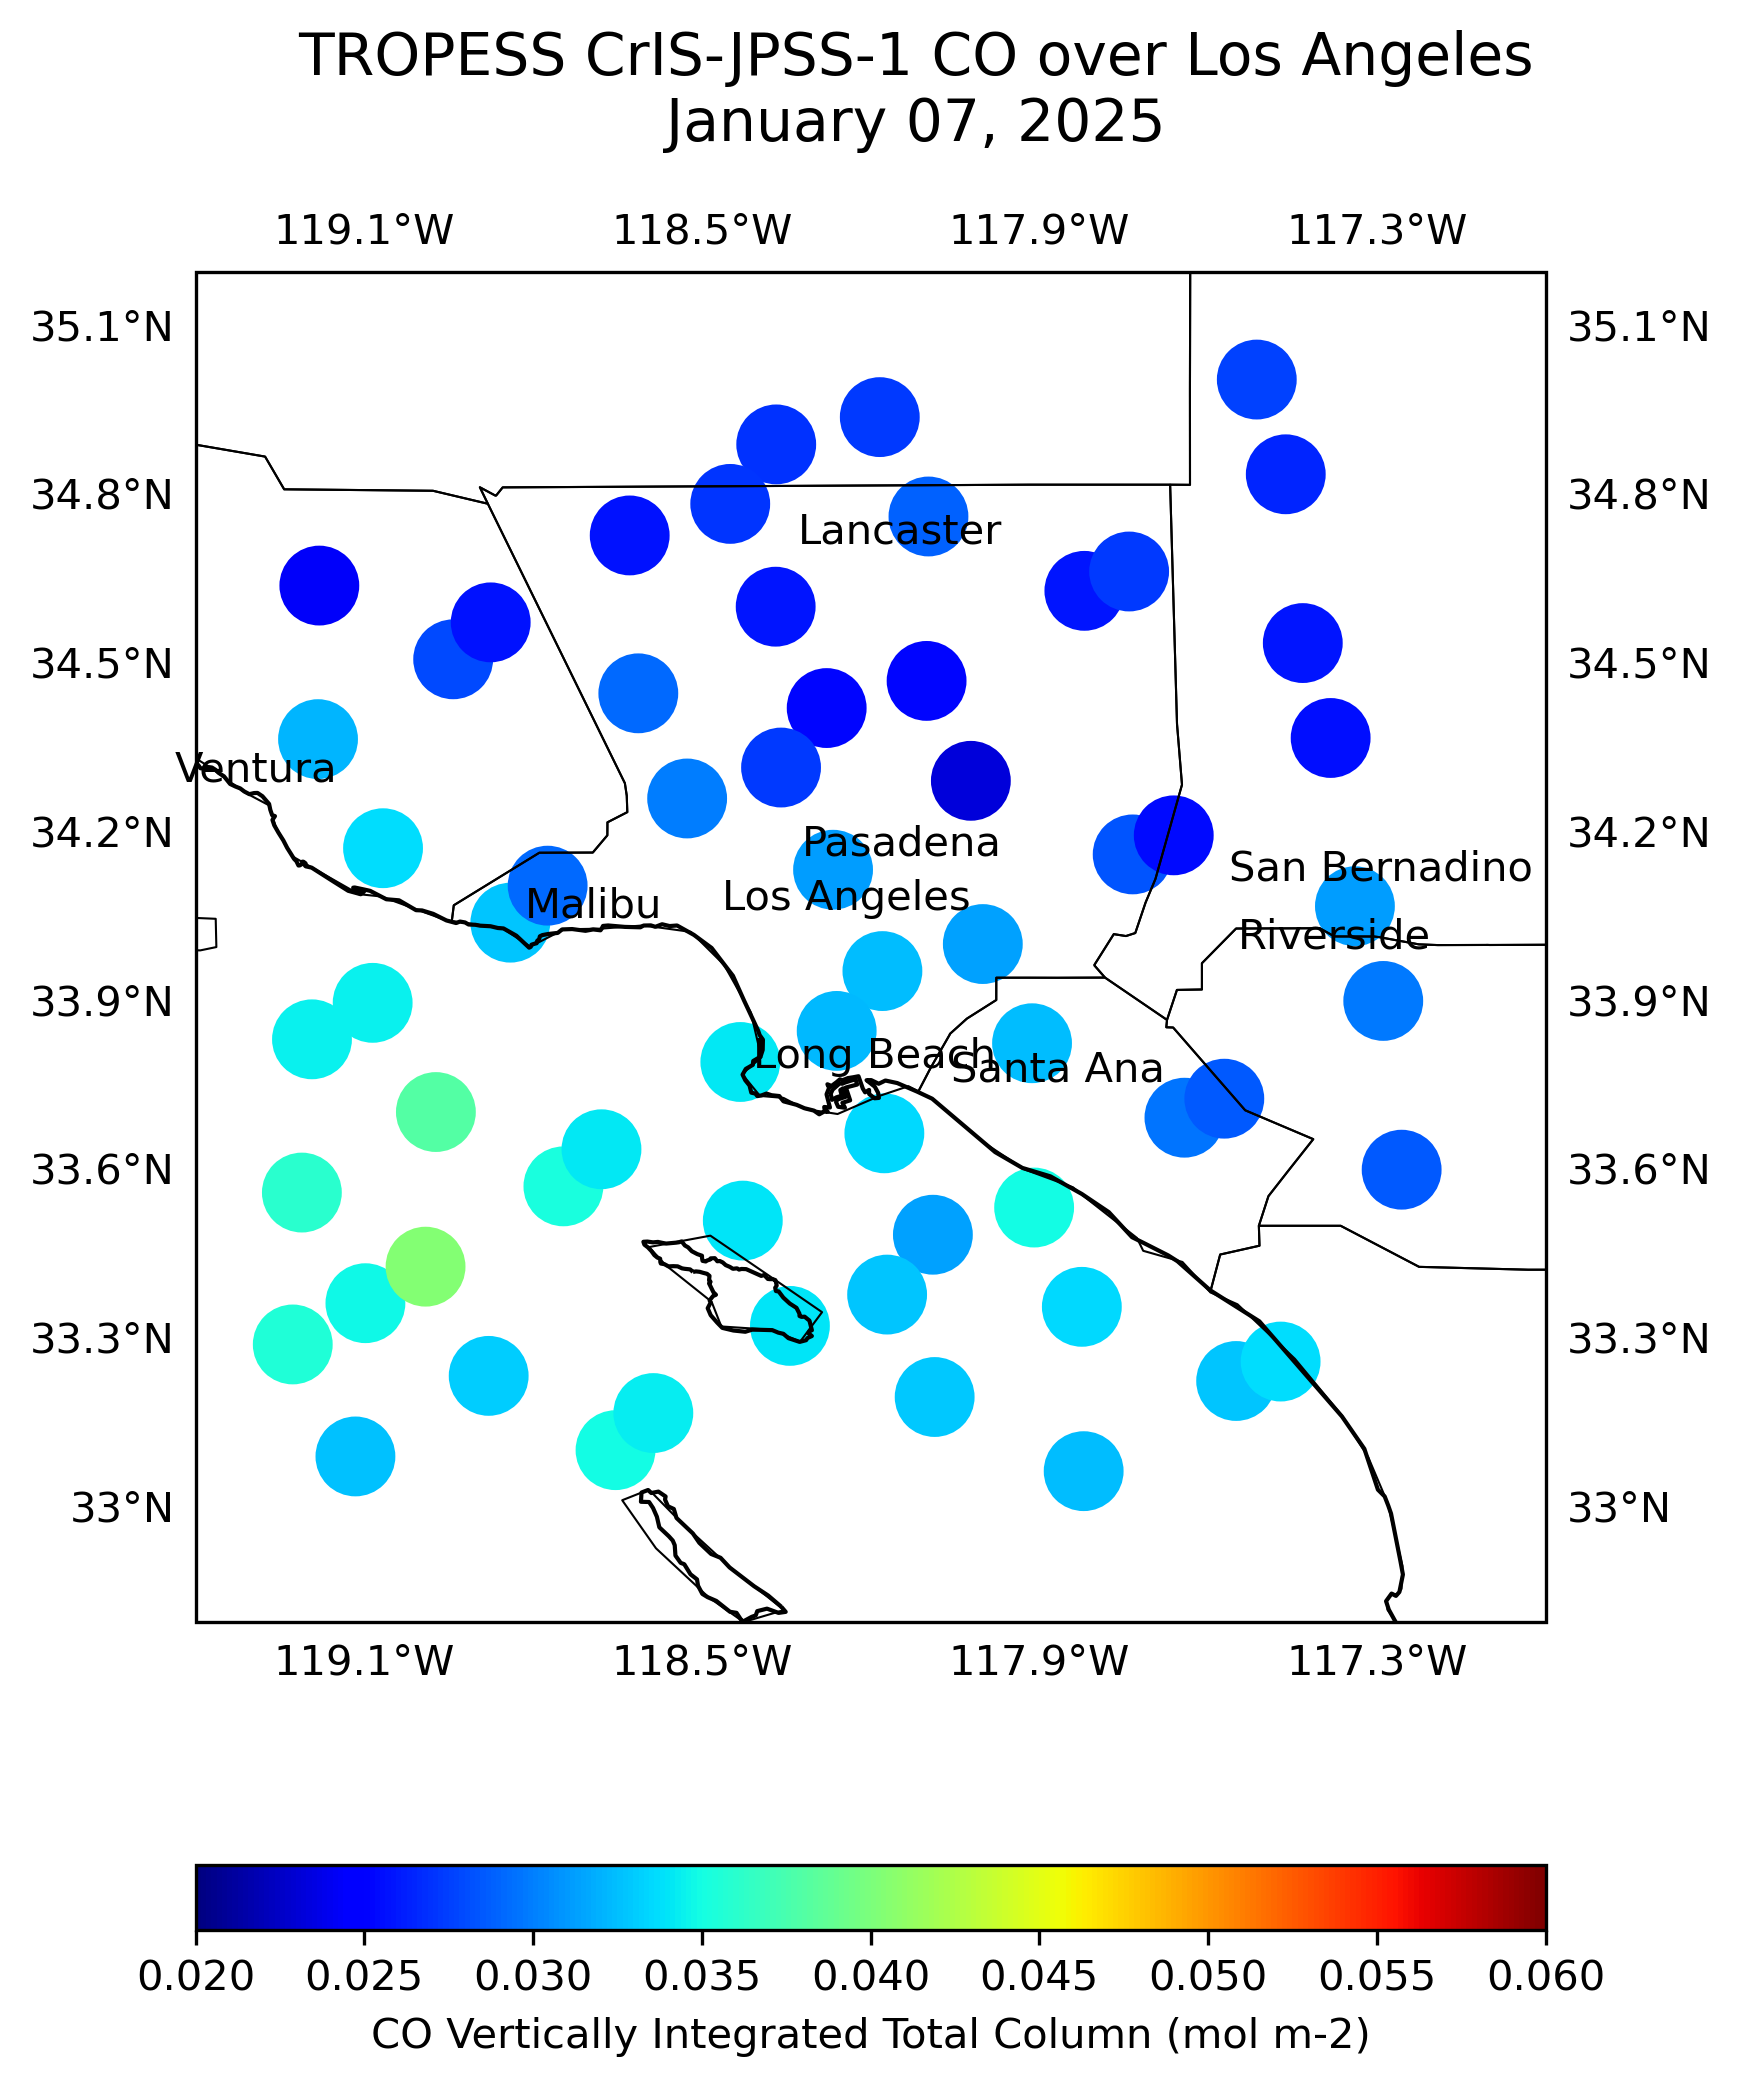

min value: 0.023613950237631798, max value: 0.08531162142753601


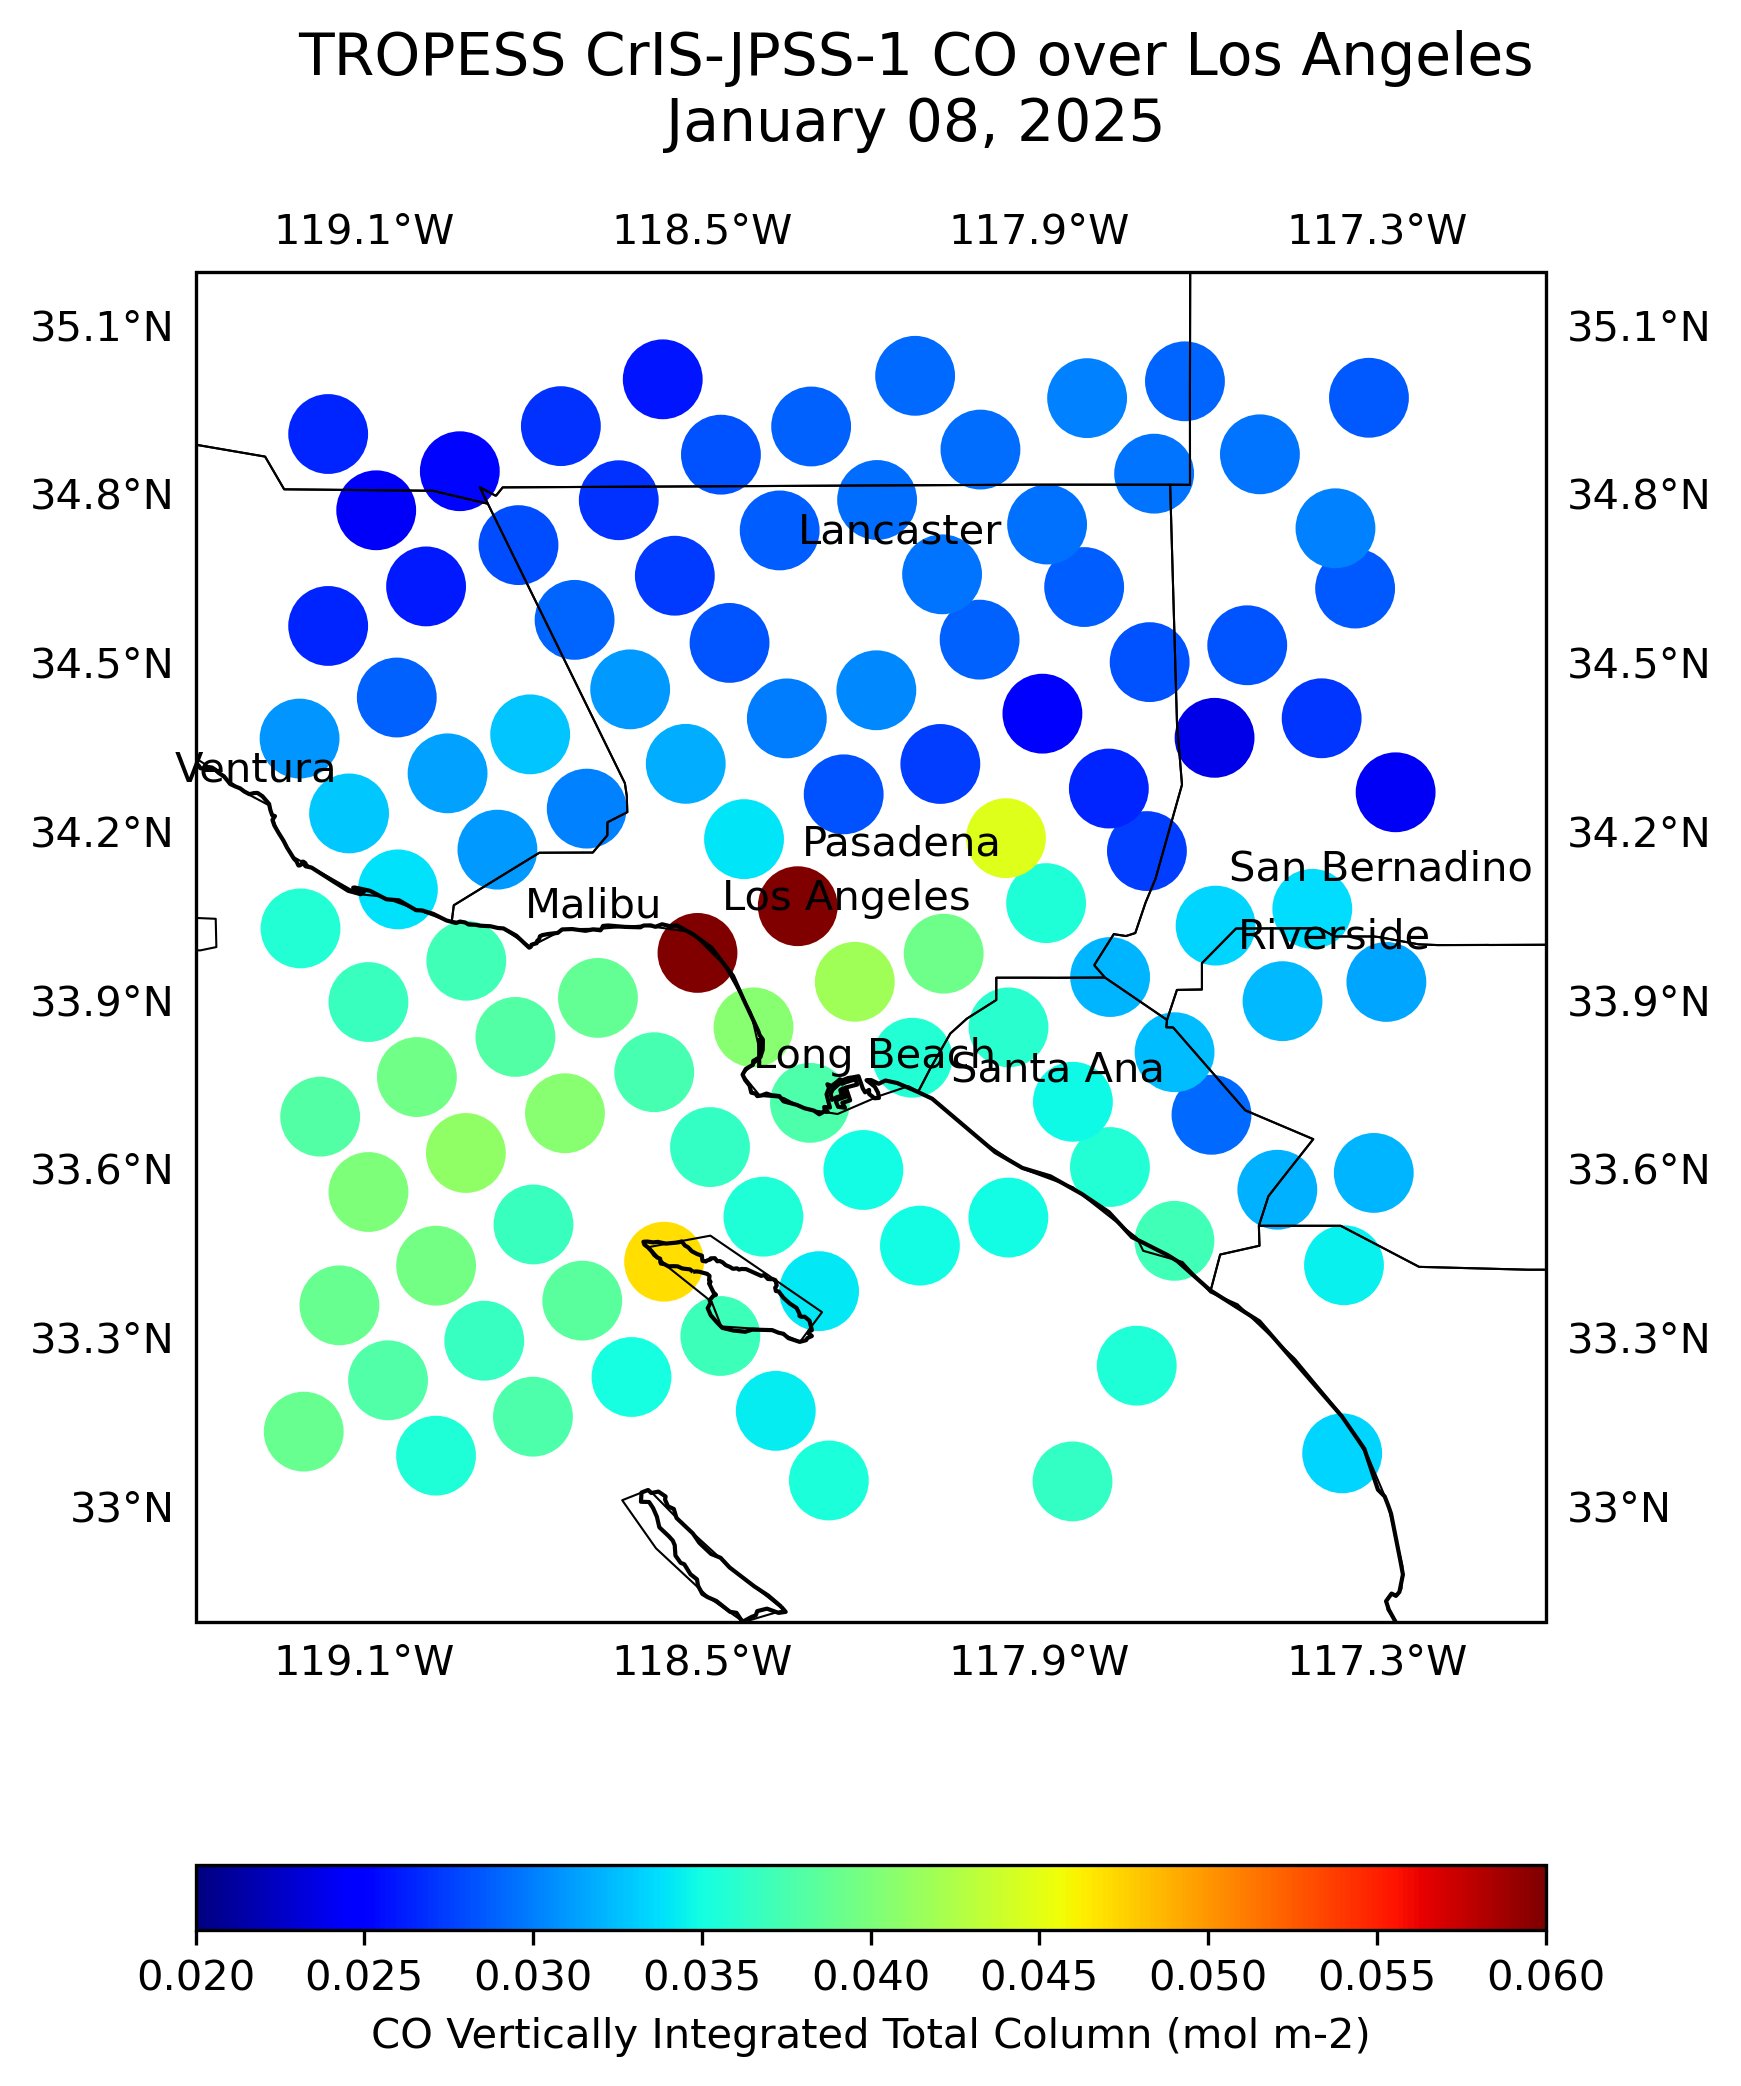

min value: 0.02437618002295494, max value: 0.07992676645517349


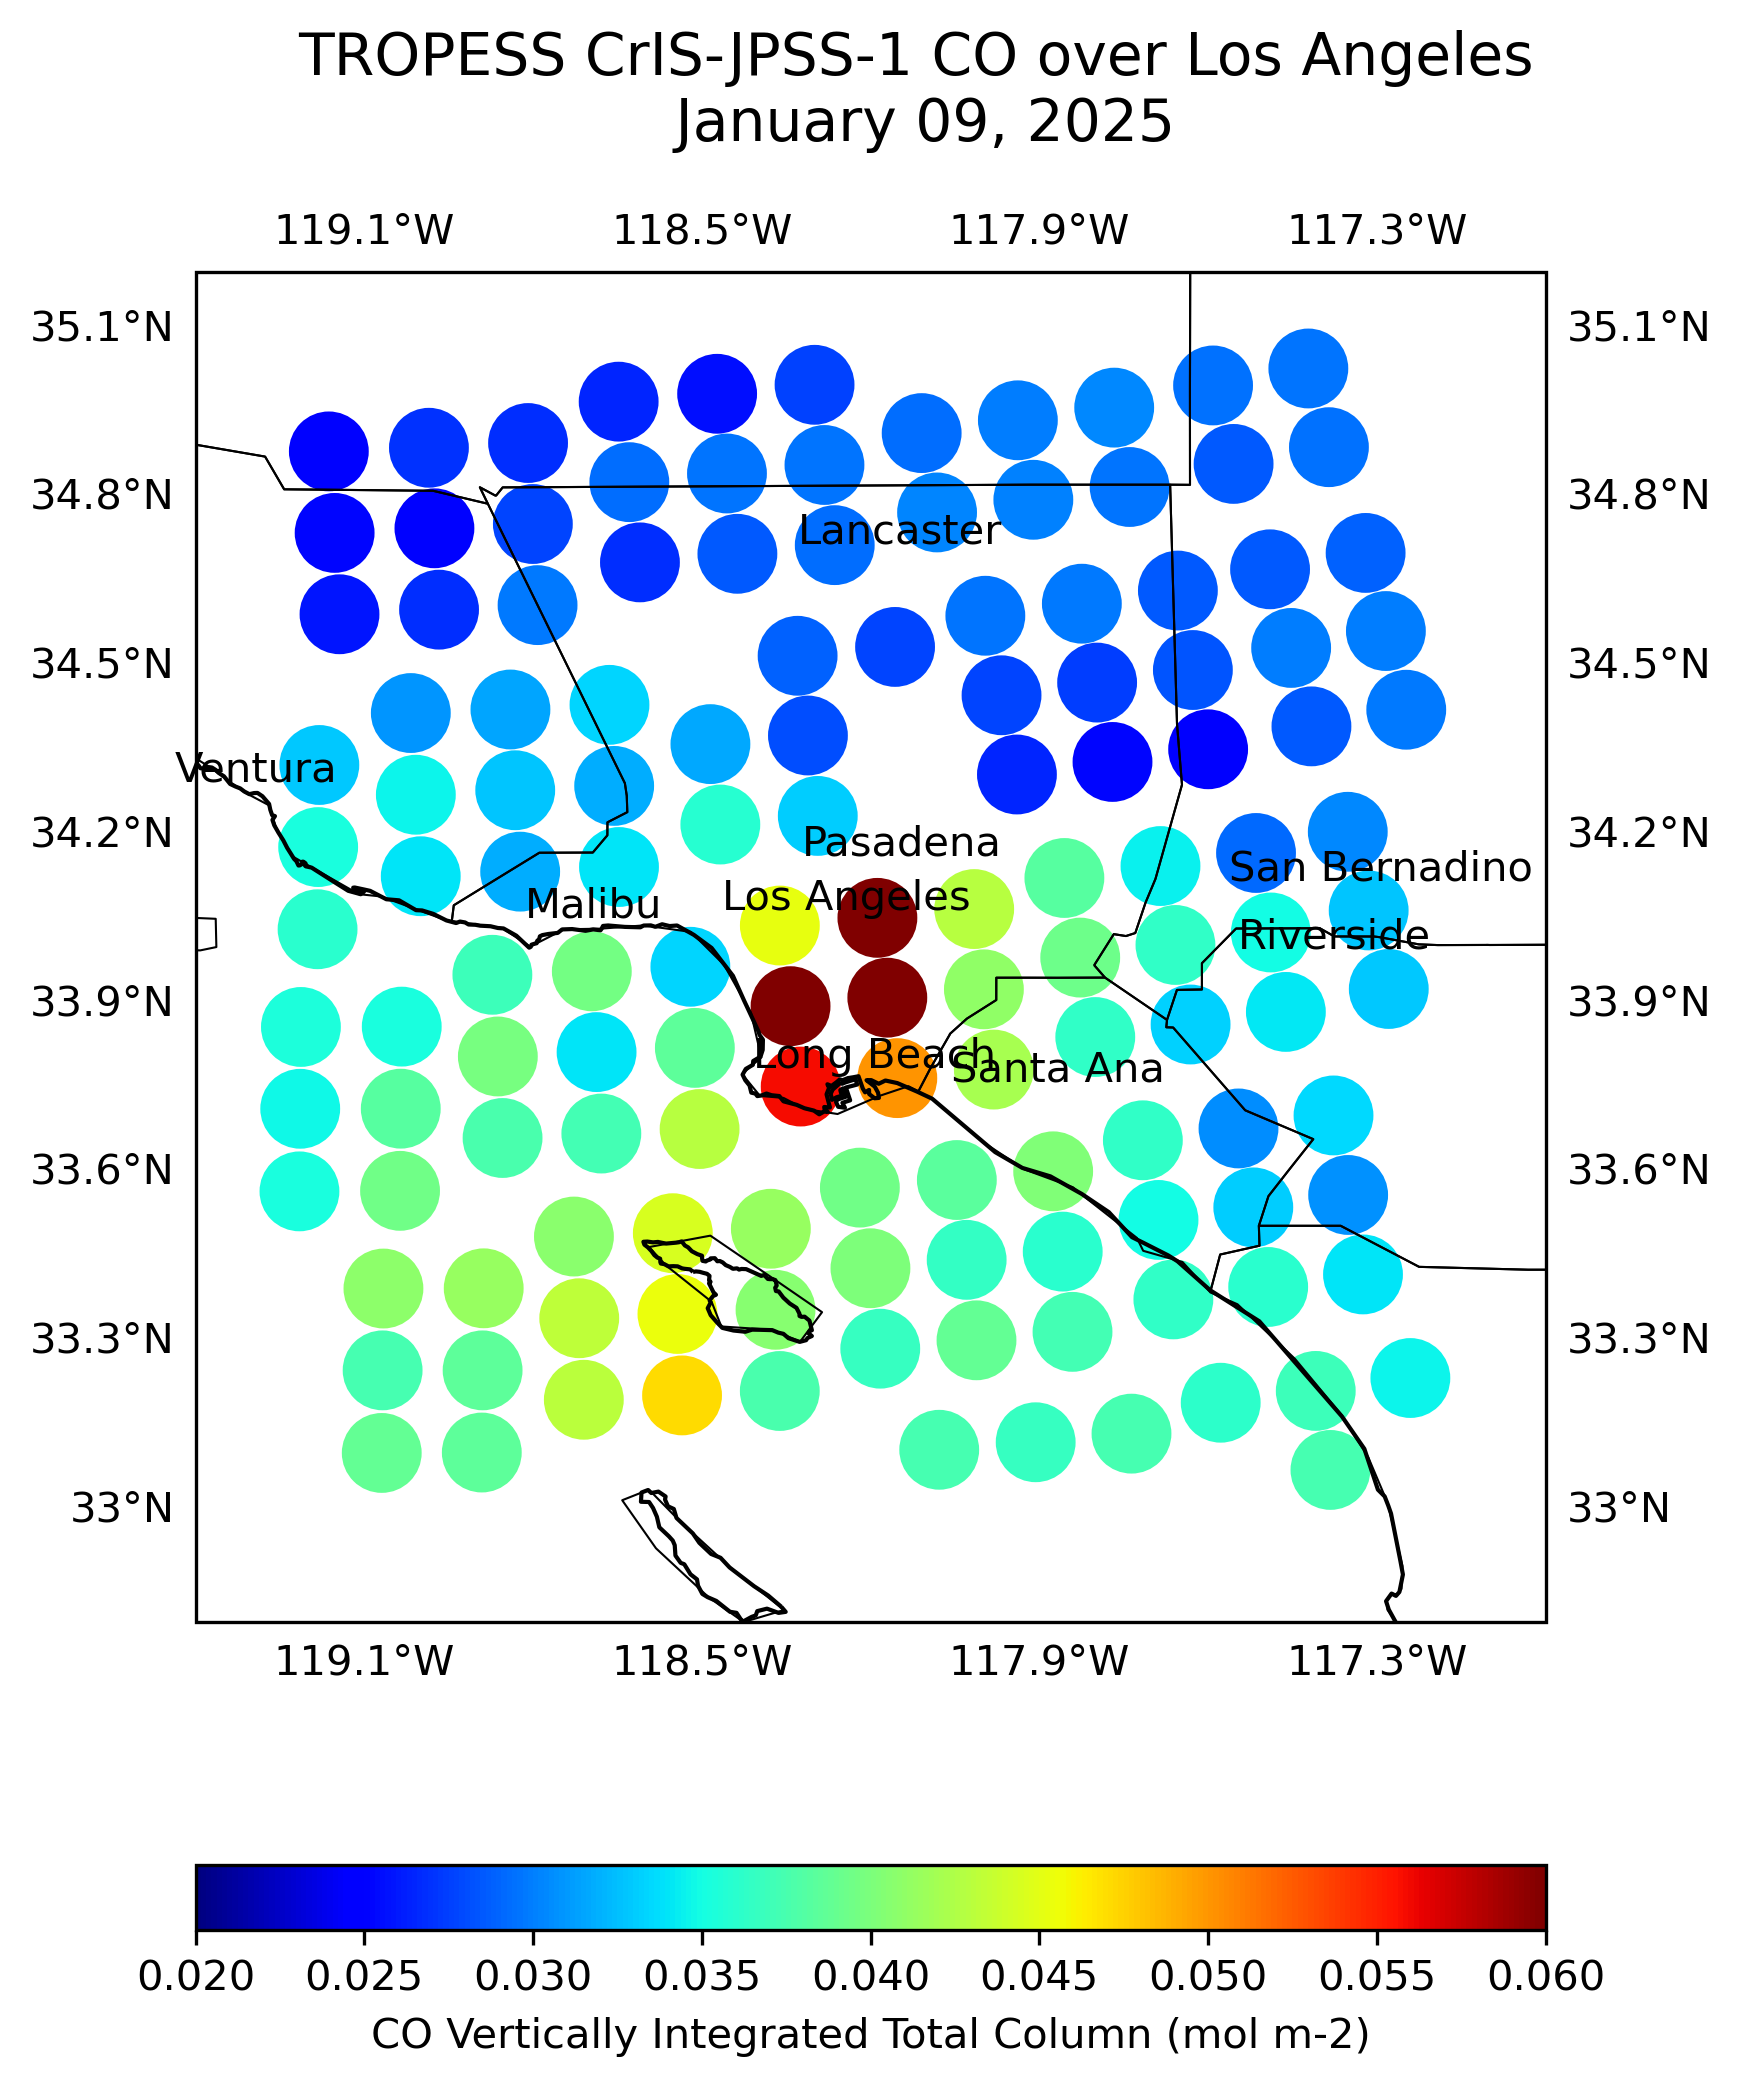

min value: 0.02429155819118023, max value: 0.04779020696878433


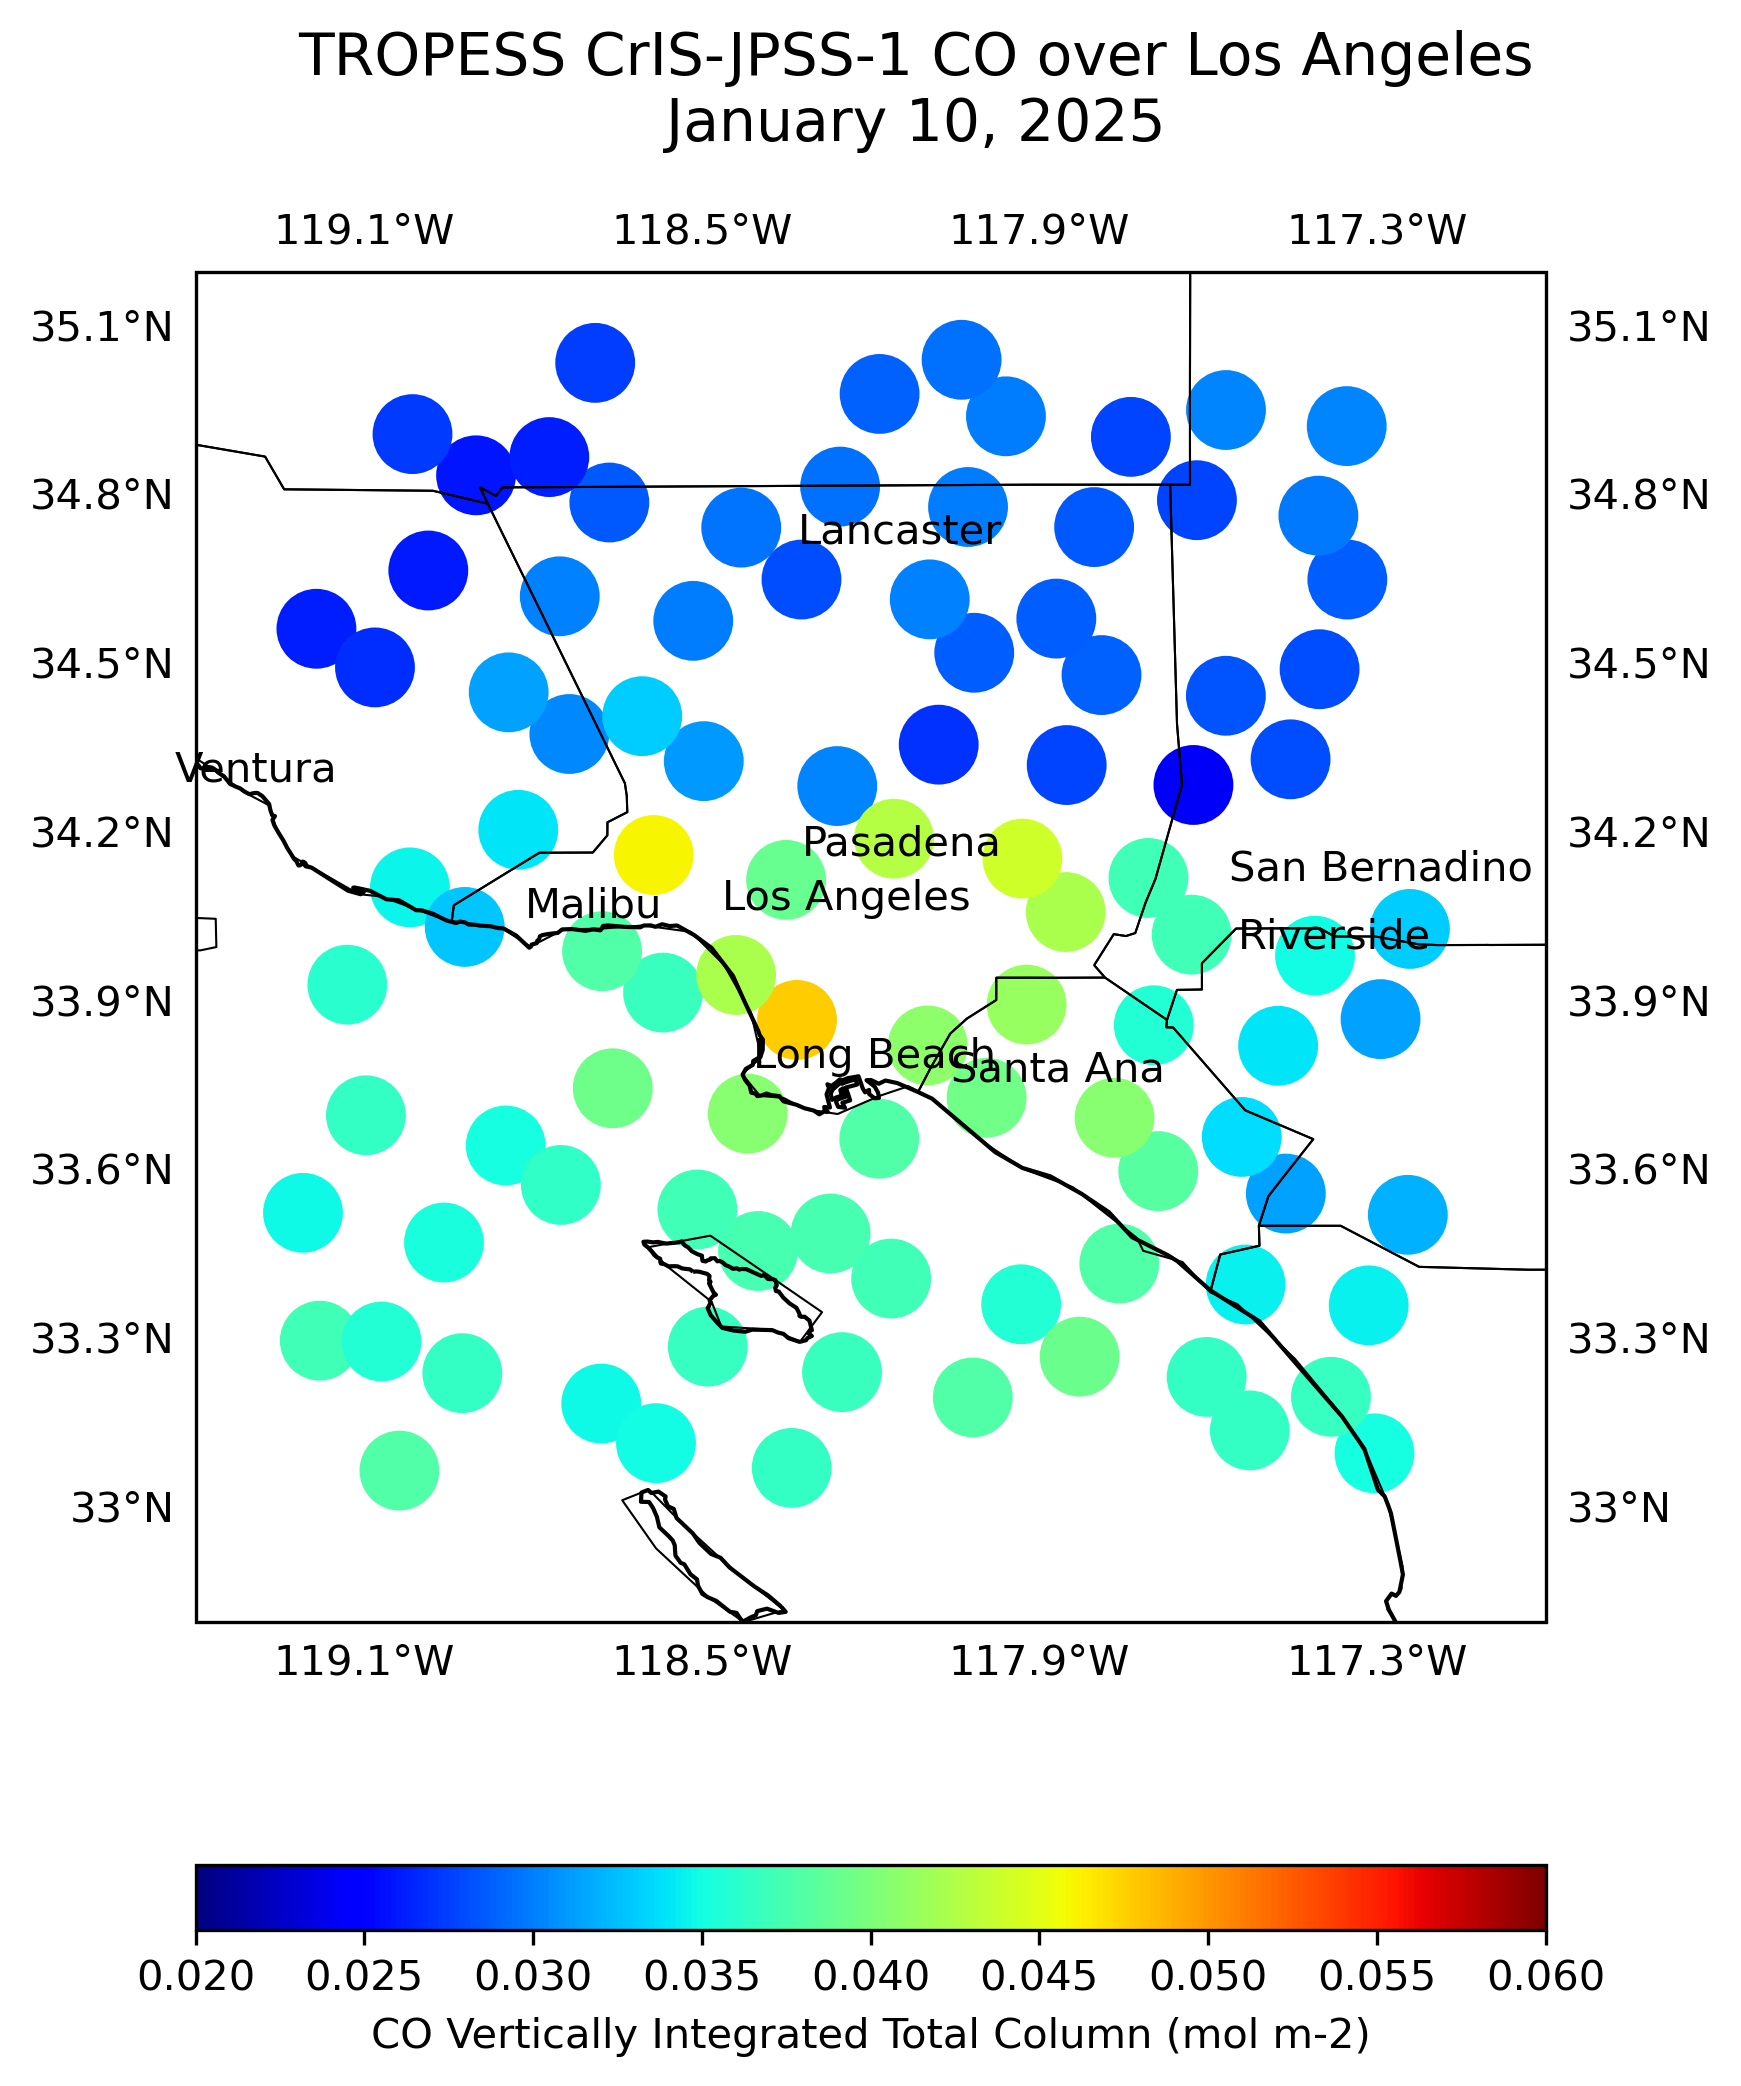

In [20]:
vmin = 0.02
vmax = 0.06

filename = DOWNLOAD_DIRECTORY + '/TROPESS_CrIS-JPSS1_L2_Standard_CO_20250107_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc'
ds = xr.open_dataset(filename)
ds_aux = xr.open_dataset(filename, group='geophysical')
latitude, longitude, this_data = filter_good_col_data(ds, ds_aux, 'CO')
data_label = 'CO Vertically Integrated Total Column (mol m-2)'
figure_title = 'TROPESS CrIS-JPSS-1 CO over Los Angeles\nJanuary 07, 2025'
image_filename = PLOT_DIRECTORY + '/CO_Filtered_20250107.png'
plot_data_map(latitude, longitude, this_data, vmin, vmax, data_label, figure_title, image_filename)

filename = DOWNLOAD_DIRECTORY + '/TROPESS_CrIS-JPSS1_L2_Standard_CO_20250108_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc'
ds = xr.open_dataset(filename)
ds_aux = xr.open_dataset(filename, group='geophysical')
latitude, longitude, this_data = filter_good_col_data(ds, ds_aux, 'CO')
data_label = 'CO Vertically Integrated Total Column (mol m-2)'
figure_title = 'TROPESS CrIS-JPSS-1 CO over Los Angeles\nJanuary 08, 2025'
image_filename = PLOT_DIRECTORY + '/CO_Filtered_20250108.png'
plot_data_map(latitude, longitude, this_data, vmin, vmax, data_label, figure_title, image_filename)

filename = DOWNLOAD_DIRECTORY + '/TROPESS_CrIS-JPSS1_L2_Standard_CO_20250109_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc'
ds = xr.open_dataset(filename)
ds_aux = xr.open_dataset(filename, group='geophysical')
latitude, longitude, this_data = filter_good_col_data(ds, ds_aux, 'CO')
data_label = 'CO Vertically Integrated Total Column (mol m-2)'
figure_title = 'TROPESS CrIS-JPSS-1 CO over Los Angeles\n January 09, 2025'
image_filename = PLOT_DIRECTORY + '/CO_Filtered_20250109.png'
plot_data_map(latitude, longitude, this_data, vmin, vmax, data_label, figure_title, image_filename)

filename = DOWNLOAD_DIRECTORY + '/TROPESS_CrIS-JPSS1_L2_Standard_CO_20250110_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc'
ds = xr.open_dataset(filename)
ds_aux = xr.open_dataset(filename, group='geophysical')
latitude, longitude, this_data = filter_good_col_data(ds, ds_aux, 'CO')
data_label = 'CO Vertically Integrated Total Column (mol m-2)'
figure_title = 'TROPESS CrIS-JPSS-1 CO over Los Angeles\nJanuary 10, 2025'
image_filename = PLOT_DIRECTORY + '/CO_Filtered_20250110.png'
plot_data_map(latitude, longitude, this_data, vmin, vmax, data_label, figure_title, image_filename)


## Plot PAN column values for each day from January 7 to January 10, 2025.

min value: -0.1233484148979187, max value: 0.37807849049568176


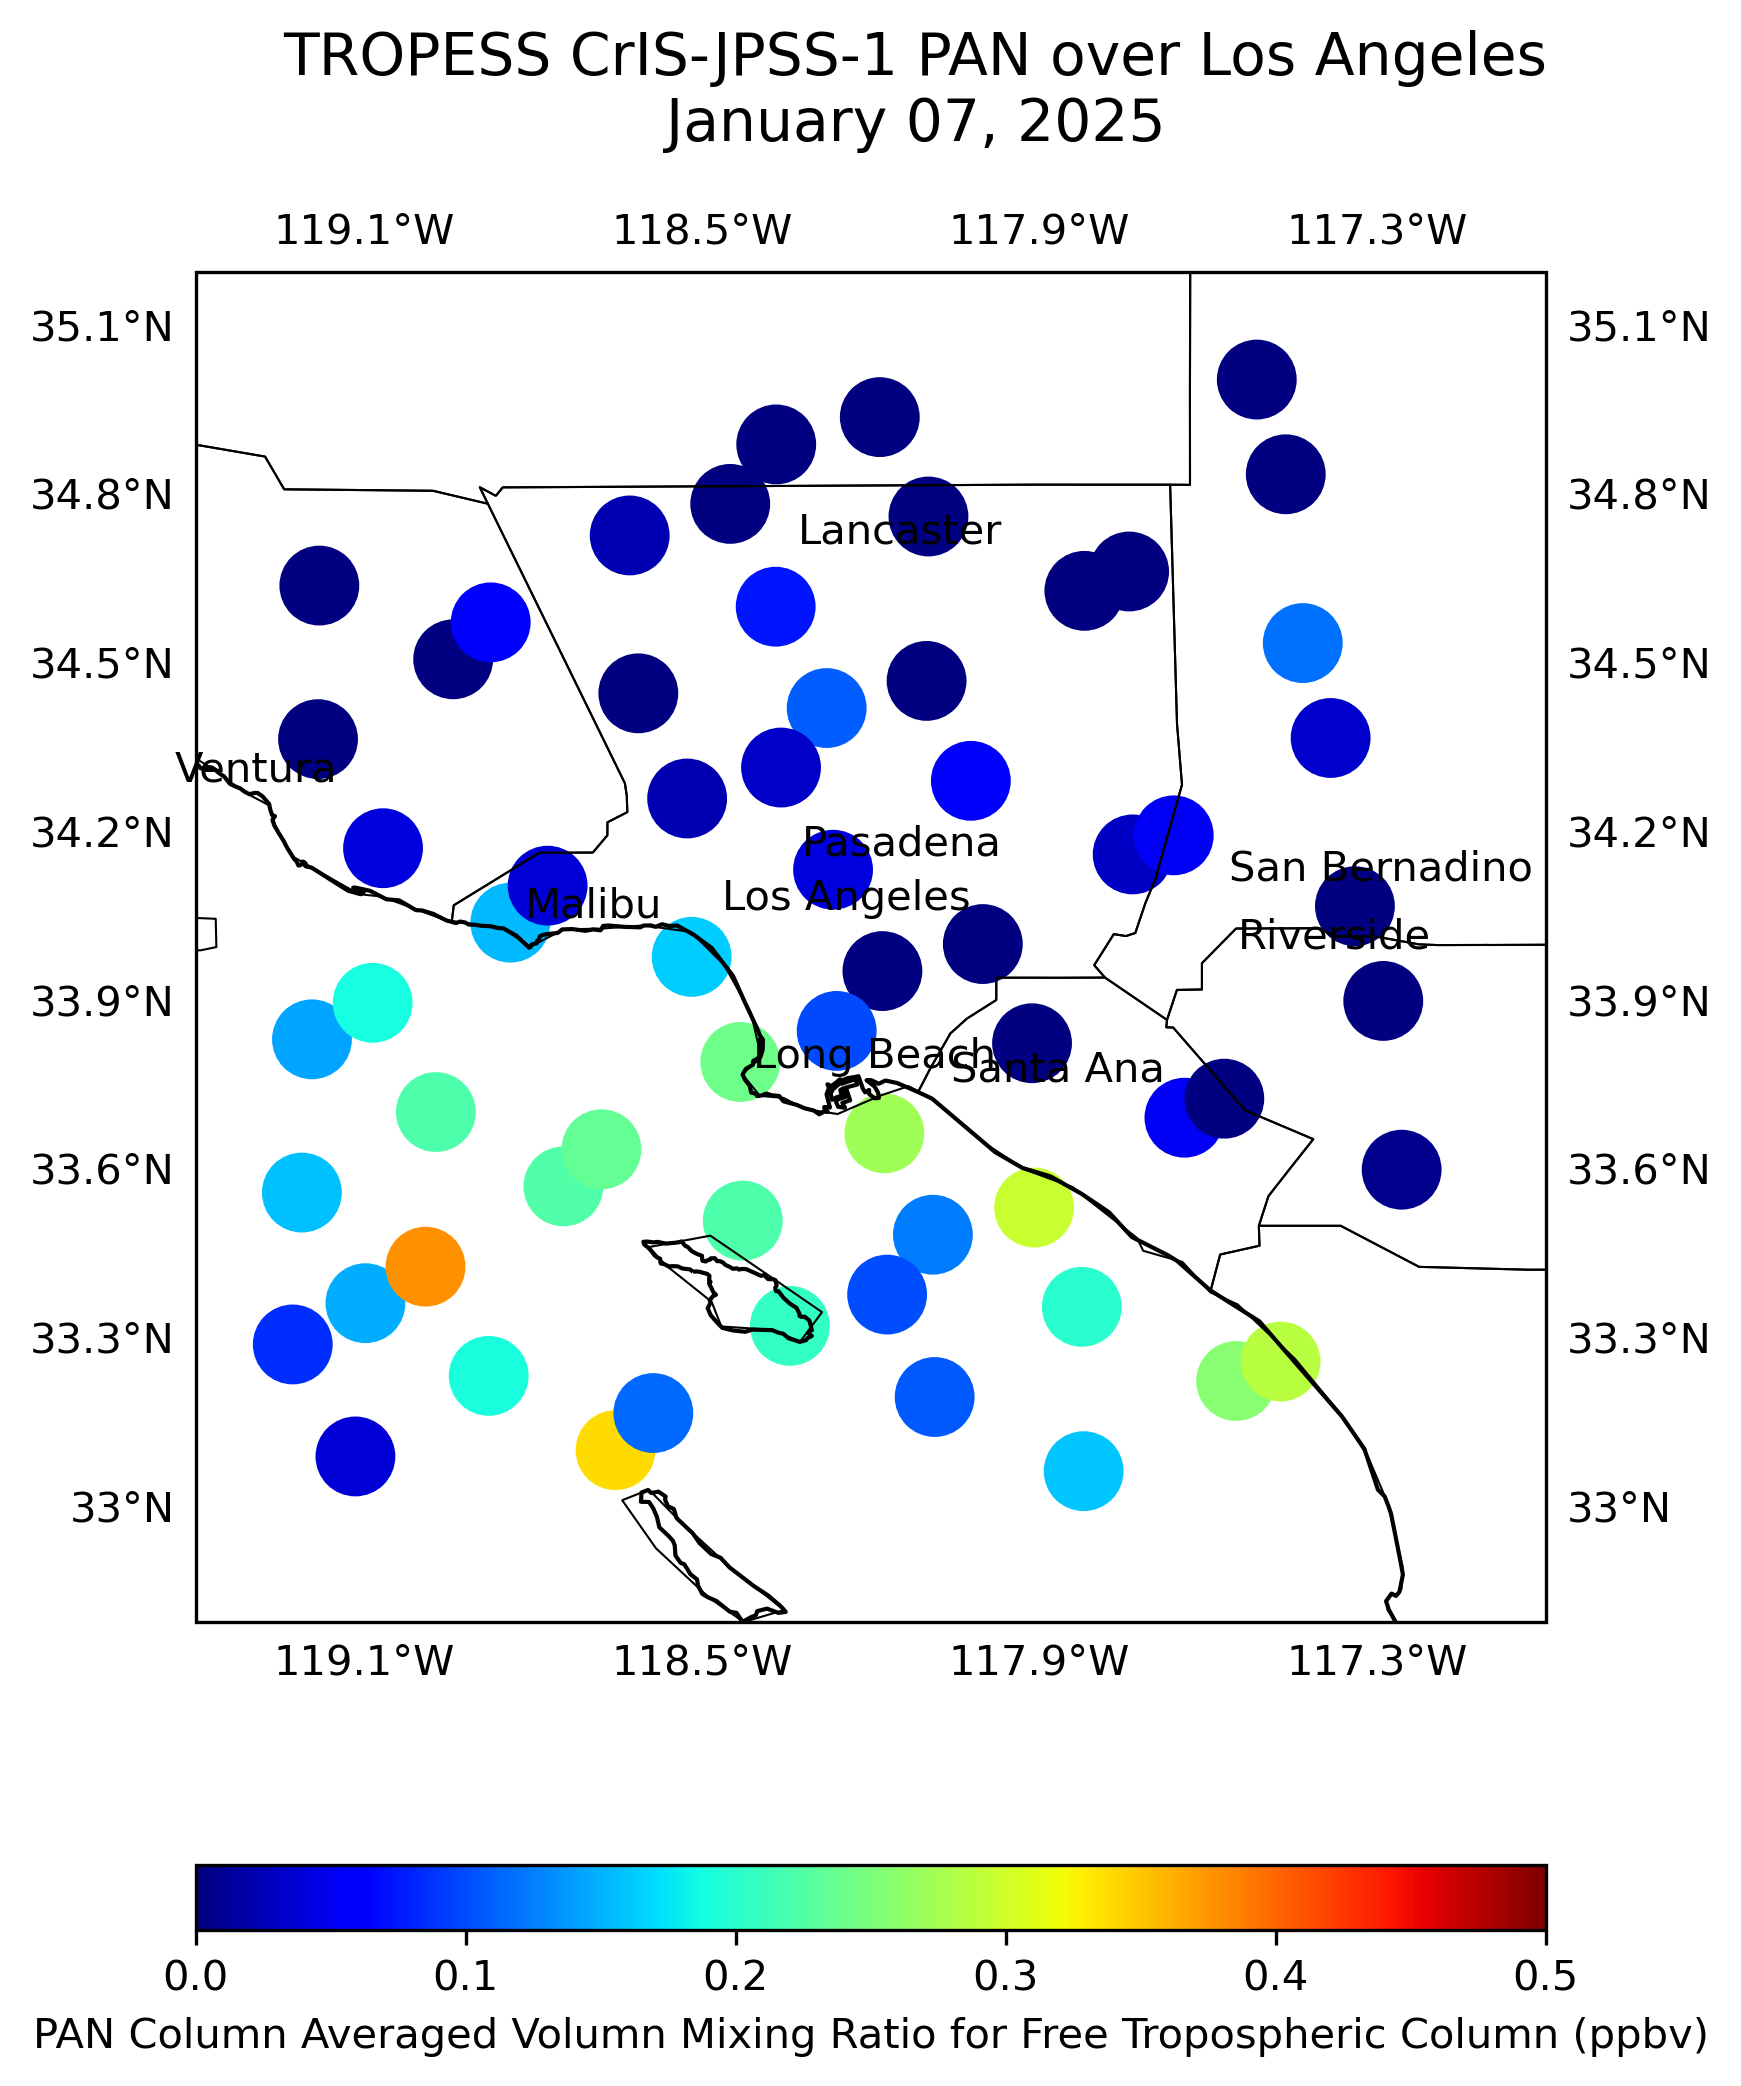

min value: -0.27632734179496765, max value: 0.3732437789440155


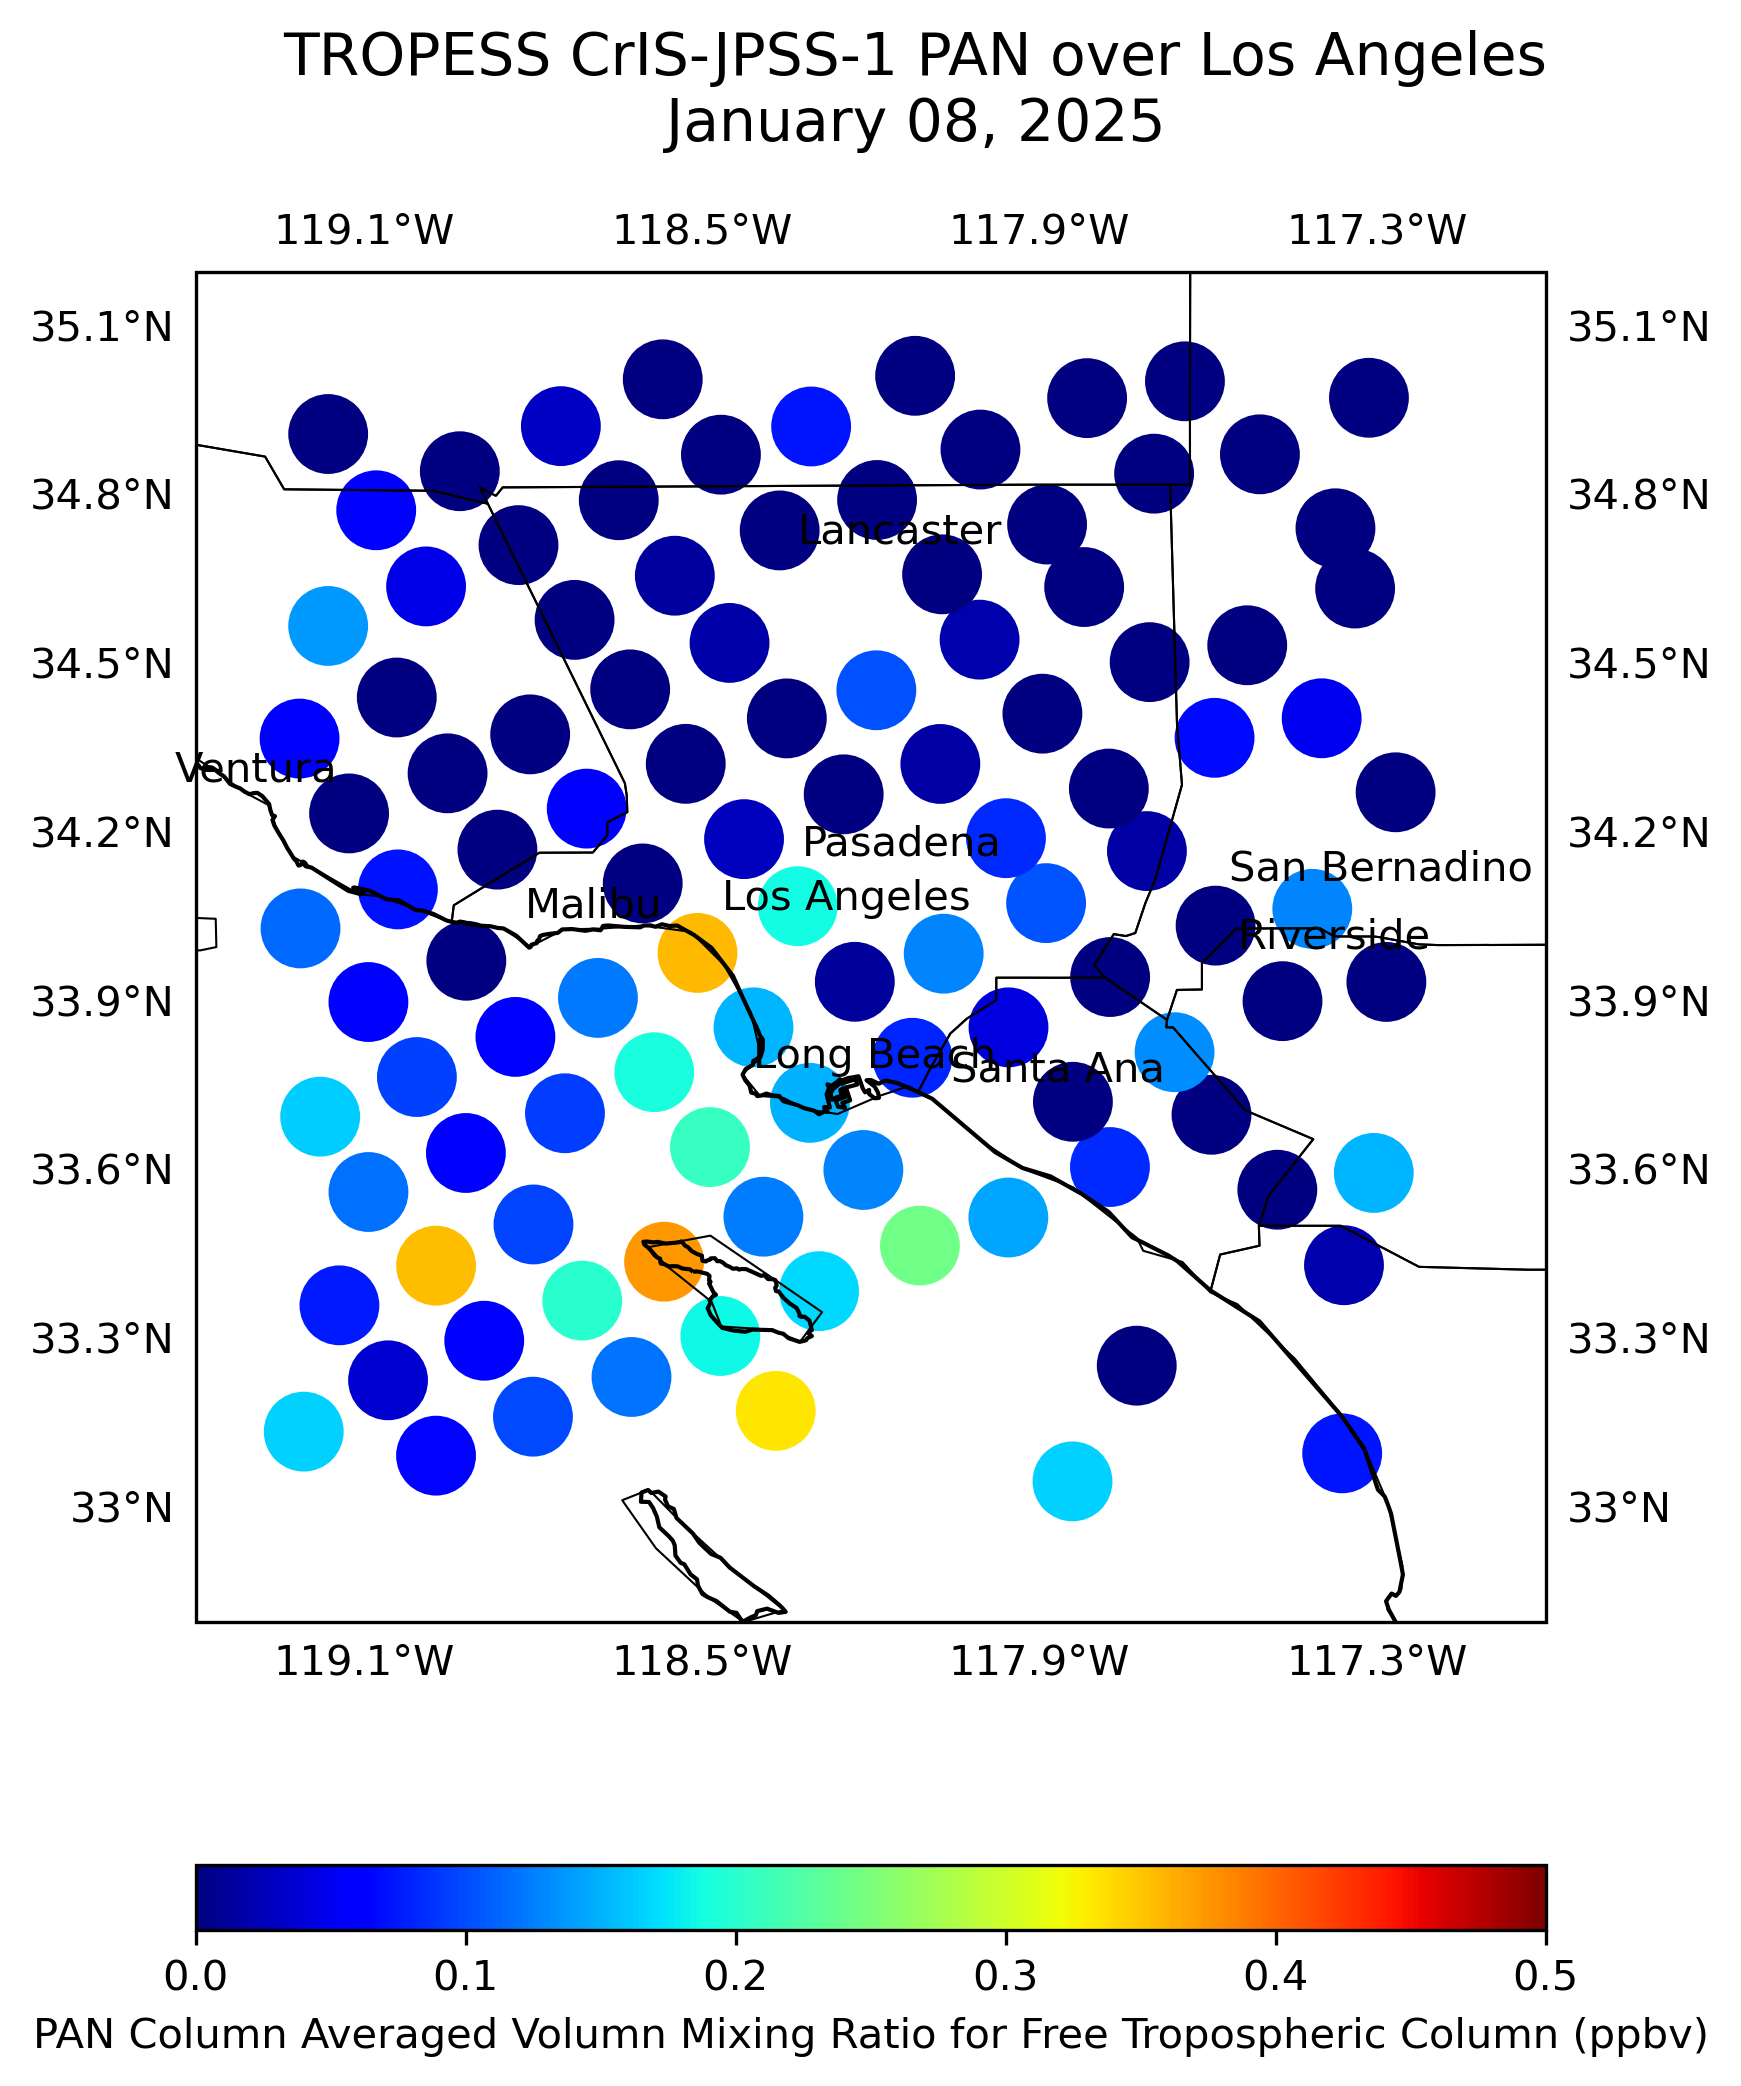

min value: -0.30141735076904297, max value: 0.5072754621505737


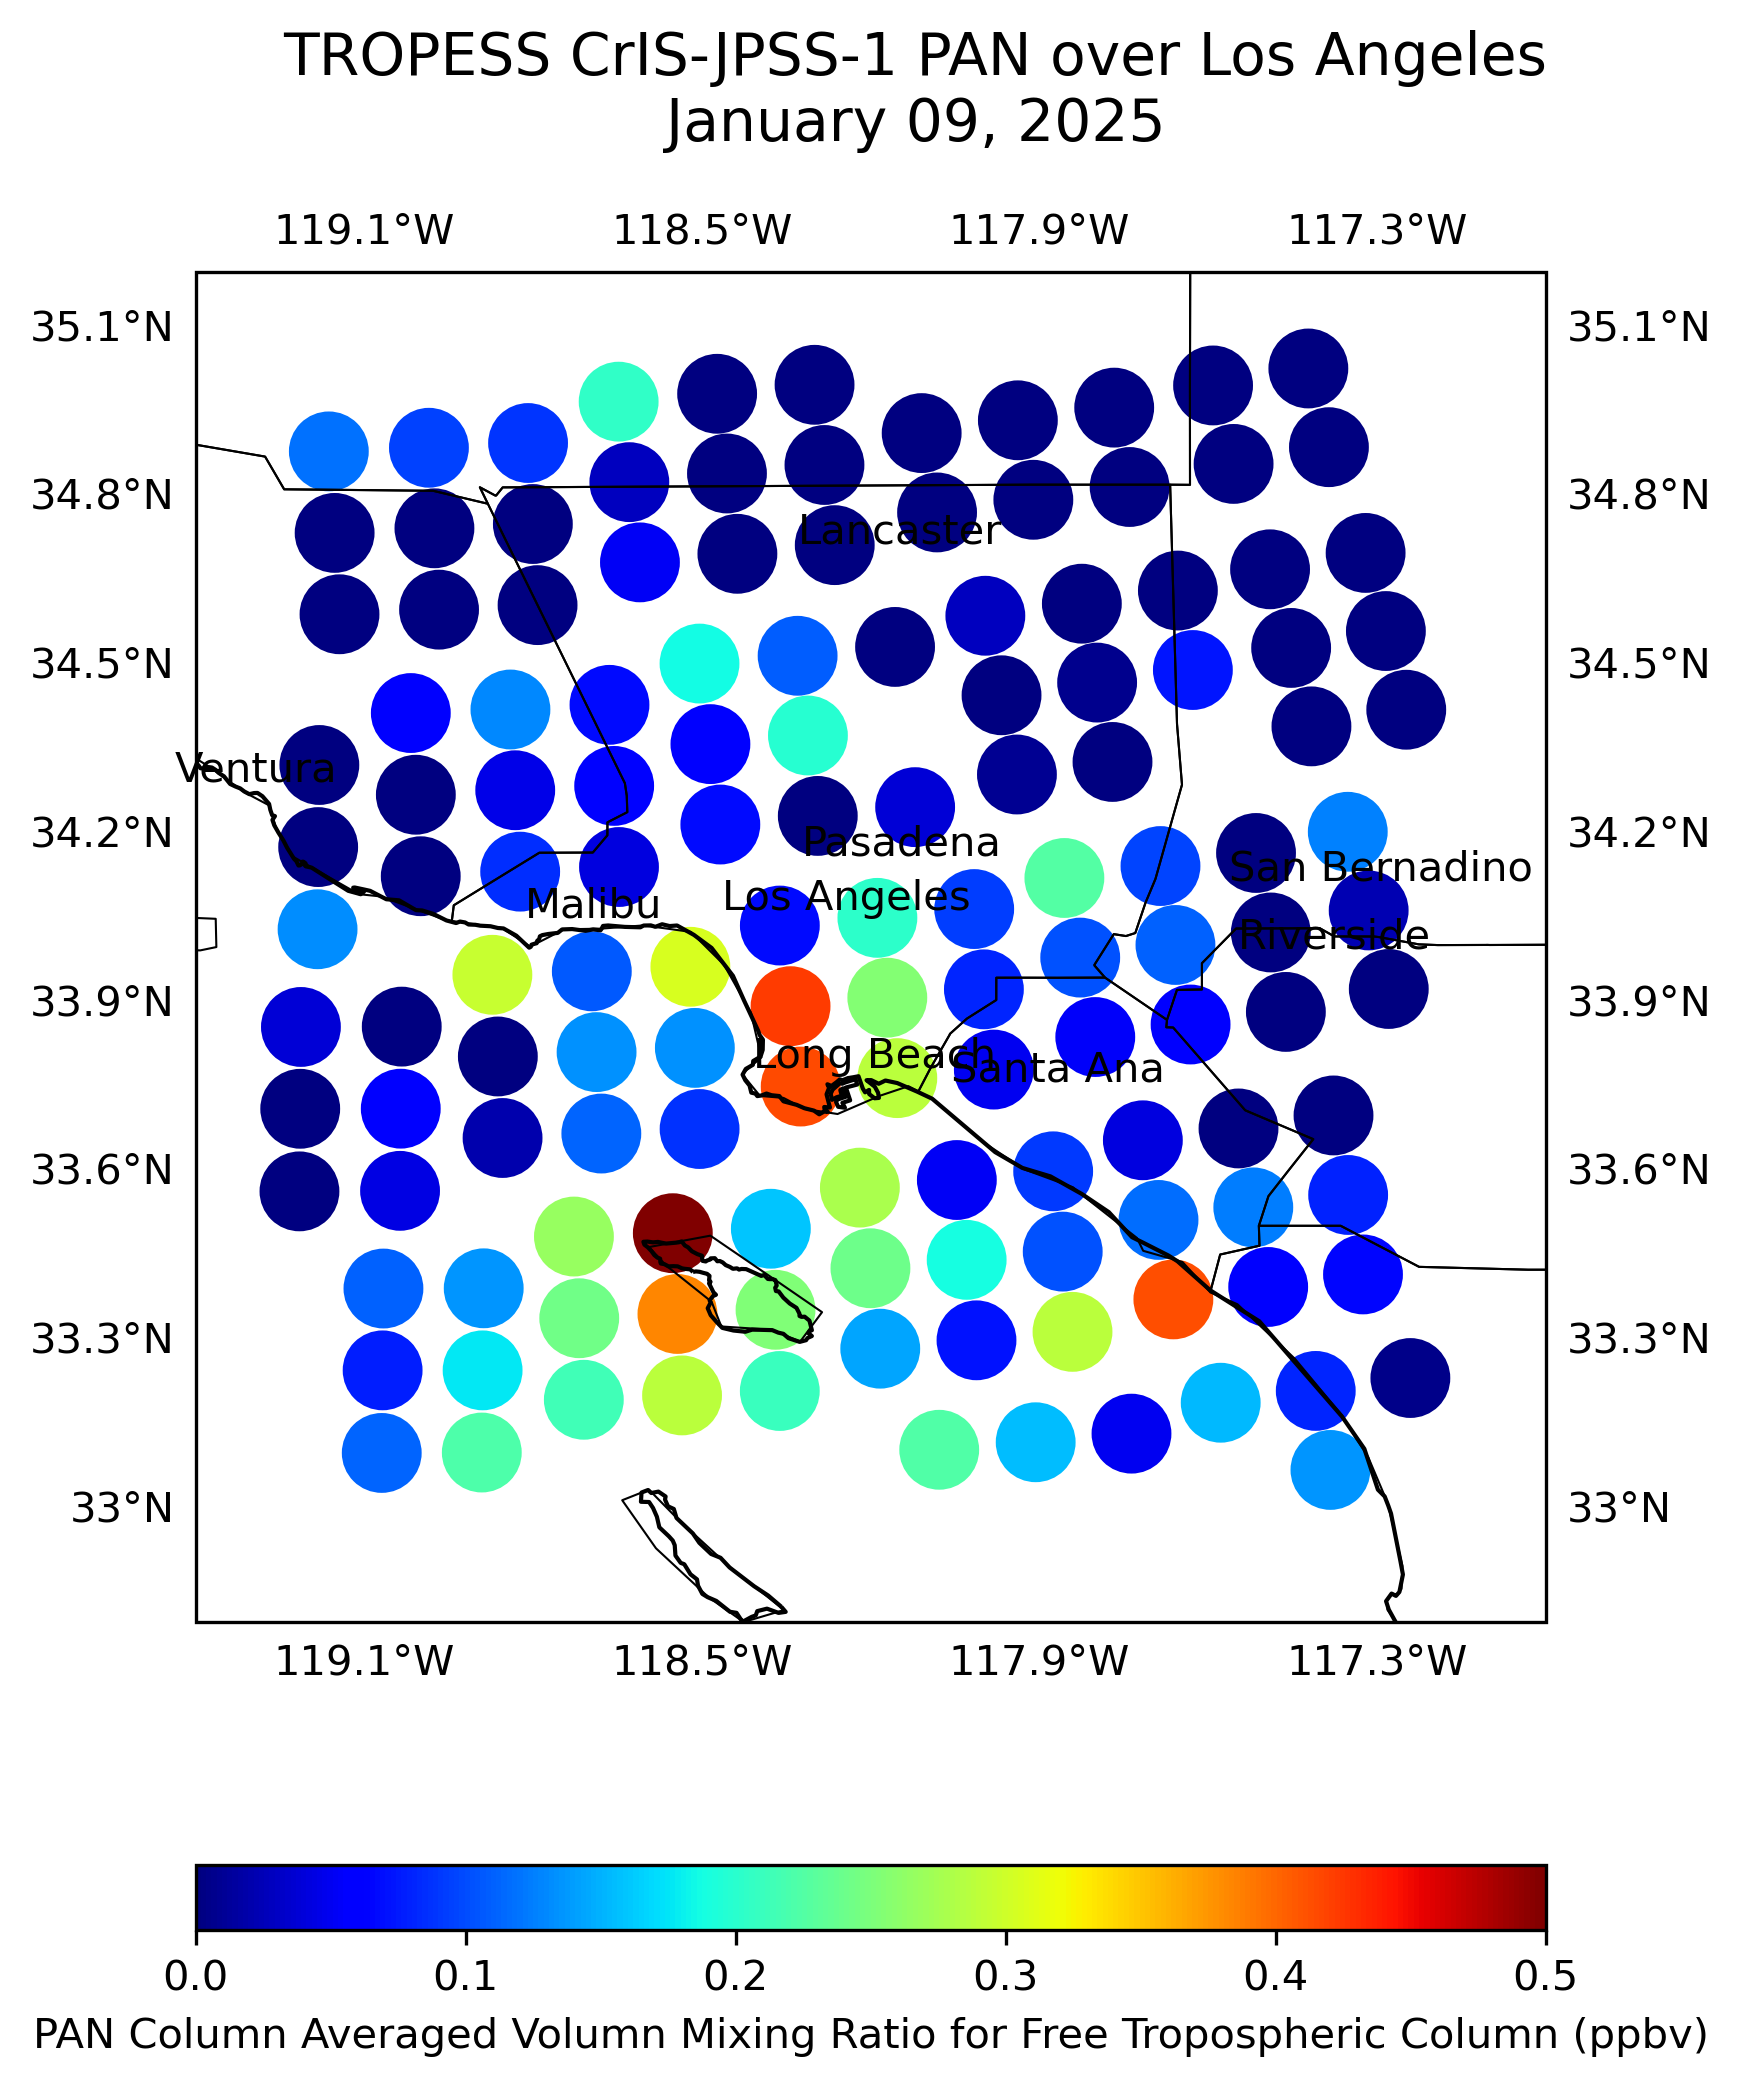

min value: -0.22127102315425873, max value: 0.5271579027175903


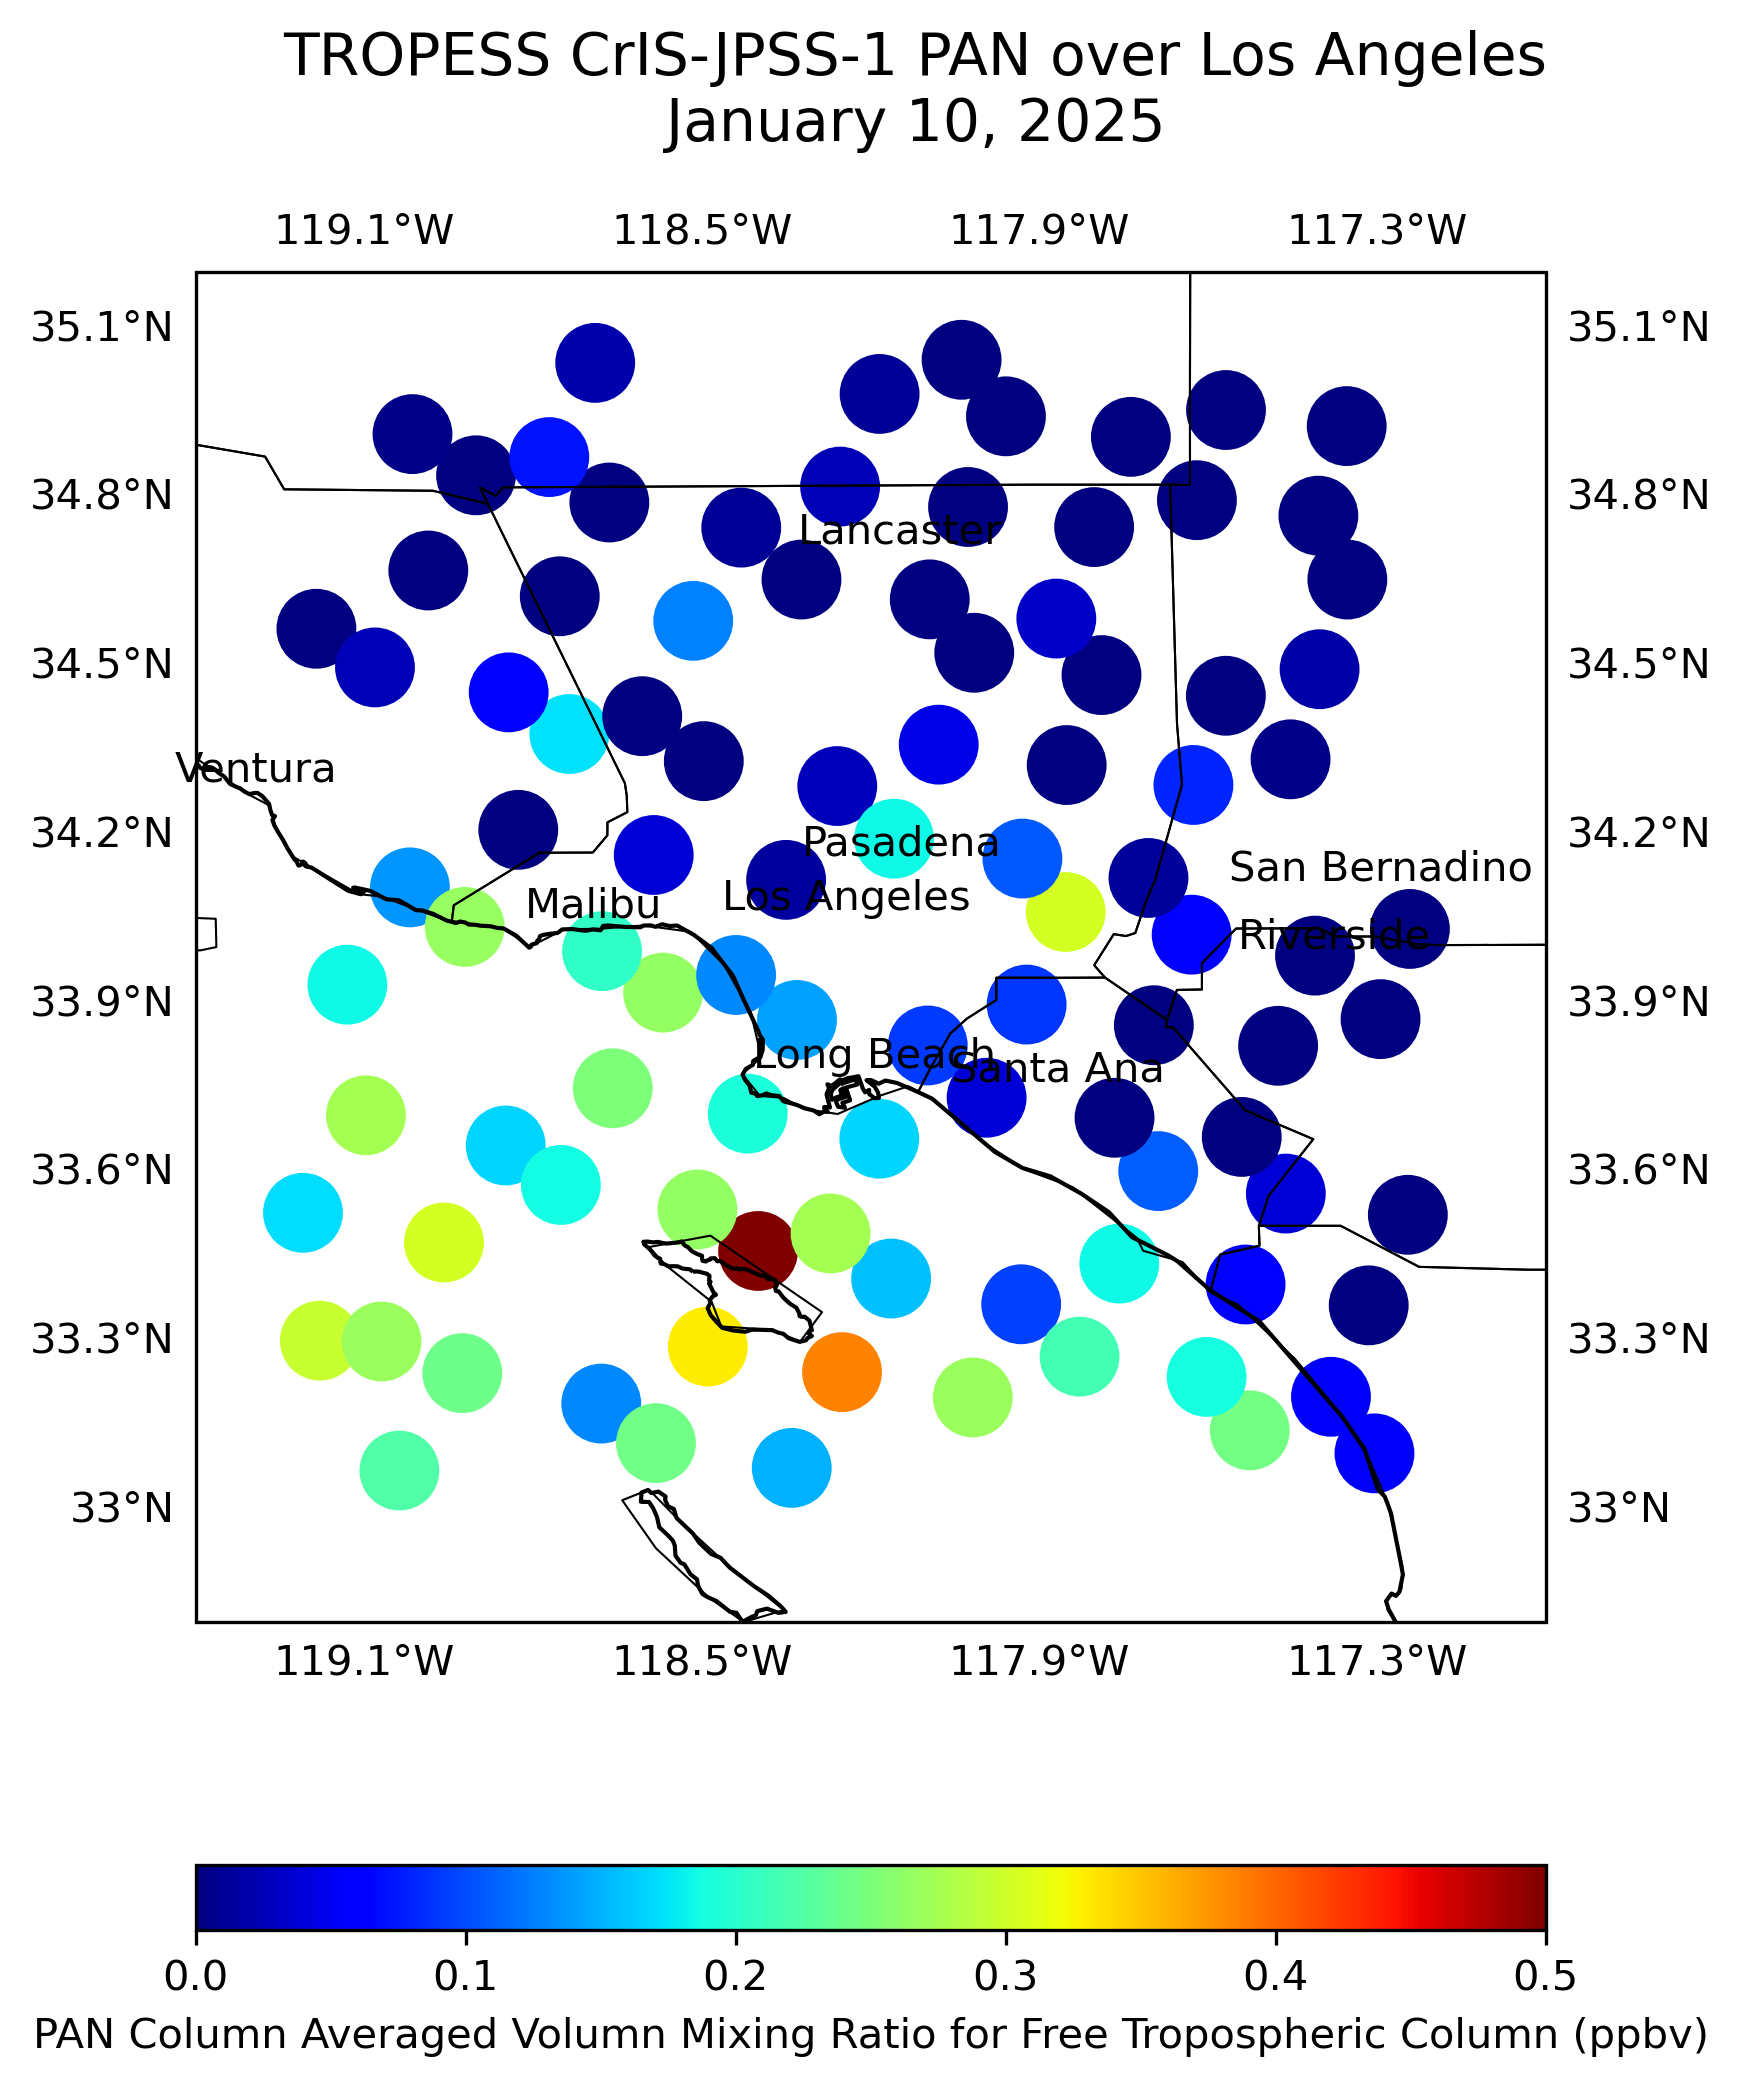

In [21]:
vmin = 0.0
vmax = 0.5

filename = DOWNLOAD_DIRECTORY + '/TROPESS_CrIS-JPSS1_L2_Standard_PAN_20250107_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc'
ds = xr.open_dataset(filename)
ds_aux = xr.open_dataset(filename, group='geophysical')
latitude, longitude, this_data = filter_good_col_data(ds, ds_aux, 'PAN')
data_label = 'PAN Column Averaged Volumn Mixing Ratio for Free Tropospheric Column (ppbv)'
figure_title = 'TROPESS CrIS-JPSS-1 PAN over Los Angeles\nJanuary 07, 2025'
image_filename = PLOT_DIRECTORY + '/PAN_Filtered_20250107.png'
plot_data_map(latitude, longitude, this_data, vmin, vmax, data_label, figure_title, image_filename)

filename = DOWNLOAD_DIRECTORY + '/TROPESS_CrIS-JPSS1_L2_Standard_PAN_20250108_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc'
ds = xr.open_dataset(filename)
ds_aux = xr.open_dataset(filename, group='geophysical')
latitude, longitude, this_data = filter_good_col_data(ds, ds_aux, 'PAN')
data_label = 'PAN Column Averaged Volumn Mixing Ratio for Free Tropospheric Column (ppbv)'
figure_title = 'TROPESS CrIS-JPSS-1 PAN over Los Angeles\nJanuary 08, 2025'
image_filename = PLOT_DIRECTORY + '/PAN_Filtered_20250108.png'
plot_data_map(latitude, longitude, this_data, vmin, vmax, data_label, figure_title, image_filename)

filename = DOWNLOAD_DIRECTORY + '/TROPESS_CrIS-JPSS1_L2_Standard_PAN_20250109_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc'
ds = xr.open_dataset(filename)
ds_aux = xr.open_dataset(filename, group='geophysical')
latitude, longitude, this_data = filter_good_col_data(ds, ds_aux, 'PAN')
data_label = 'PAN Column Averaged Volumn Mixing Ratio for Free Tropospheric Column (ppbv)'
figure_title = 'TROPESS CrIS-JPSS-1 PAN over Los Angeles\nJanuary 09, 2025'
image_filename = PLOT_DIRECTORY + '/PAN_Filtered_20250109.png'
plot_data_map(latitude, longitude, this_data, vmin, vmax, data_label, figure_title, image_filename)

filename = DOWNLOAD_DIRECTORY + '/TROPESS_CrIS-JPSS1_L2_Standard_PAN_20250110_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc'
ds = xr.open_dataset(filename)
ds_aux = xr.open_dataset(filename, group='geophysical')
latitude, longitude, this_data = filter_good_col_data(ds, ds_aux, 'PAN')
data_label = 'PAN Column Averaged Volumn Mixing Ratio for Free Tropospheric Column (ppbv)'
figure_title = 'TROPESS CrIS-JPSS-1 PAN over Los Angeles\nJanuary 10, 2025'
image_filename = PLOT_DIRECTORY + '/PAN_Filtered_20250110.png'
plot_data_map(latitude, longitude, this_data, vmin, vmax, data_label, figure_title, image_filename)



## Plot NH3 column values for each day from January 7 to January 10, 2025.

min value: 0.03971230983734131, max value: 29.85037612915039


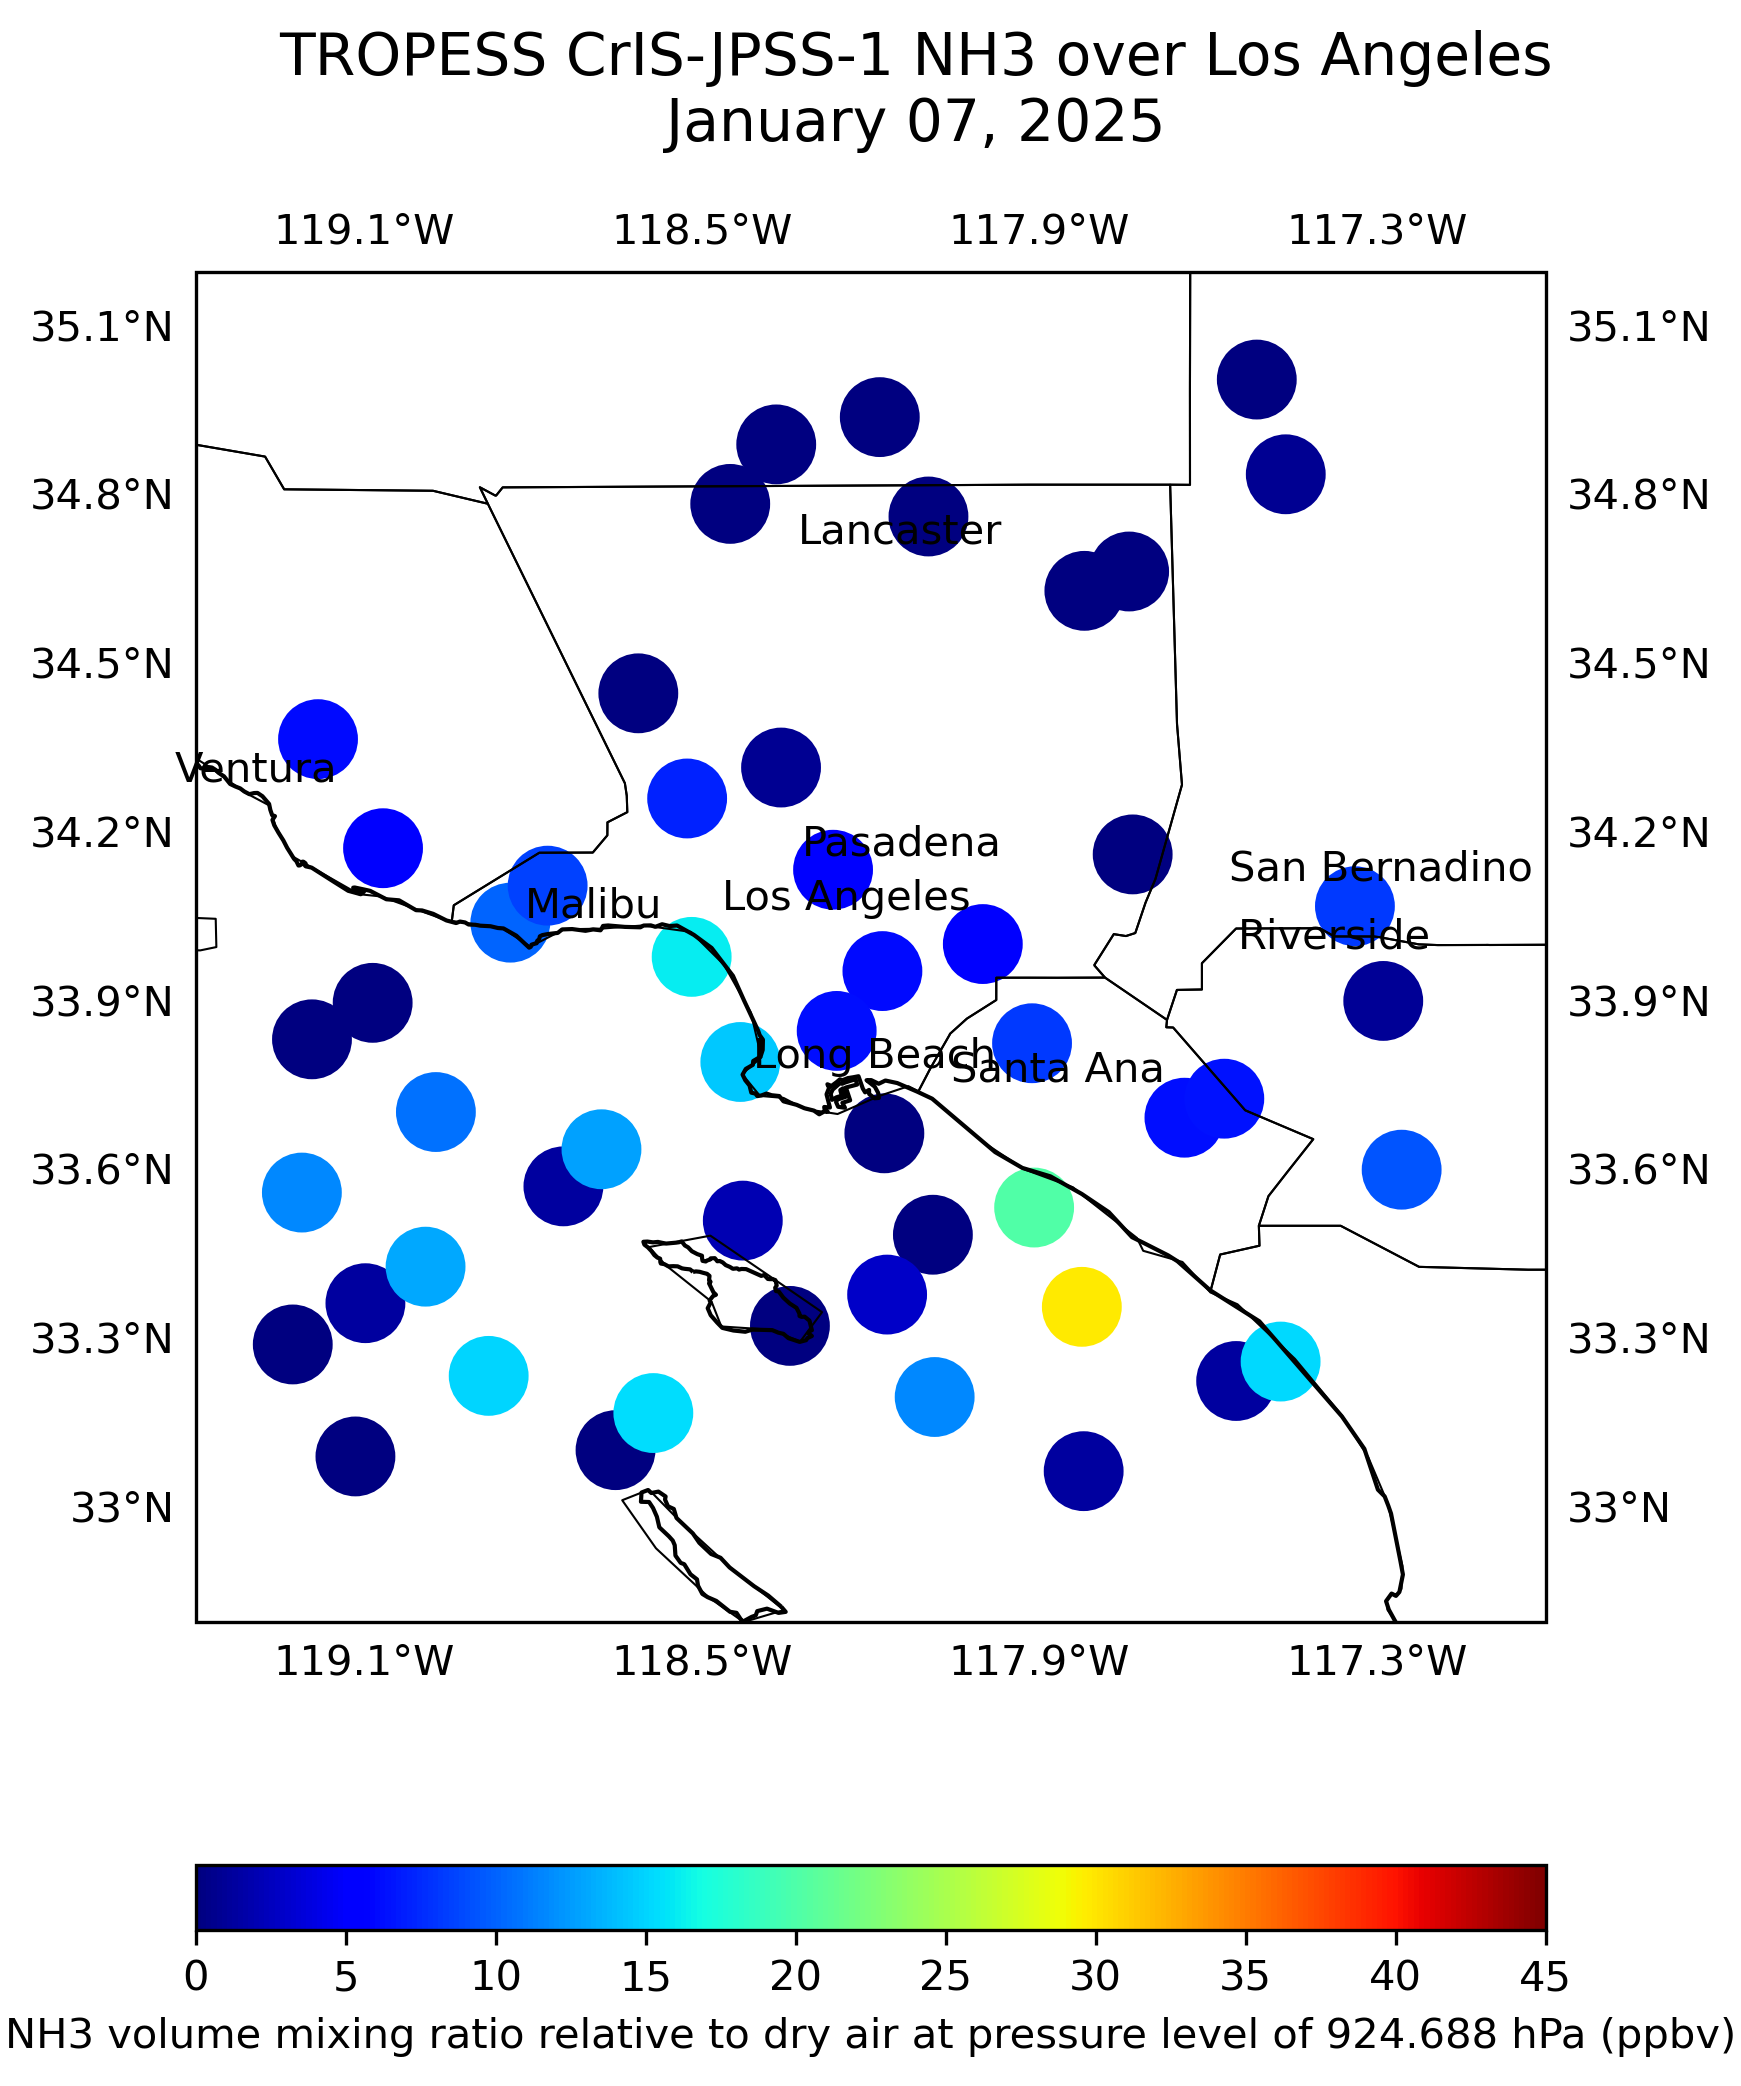

min value: 0.031883880496025085, max value: 39.8082275390625


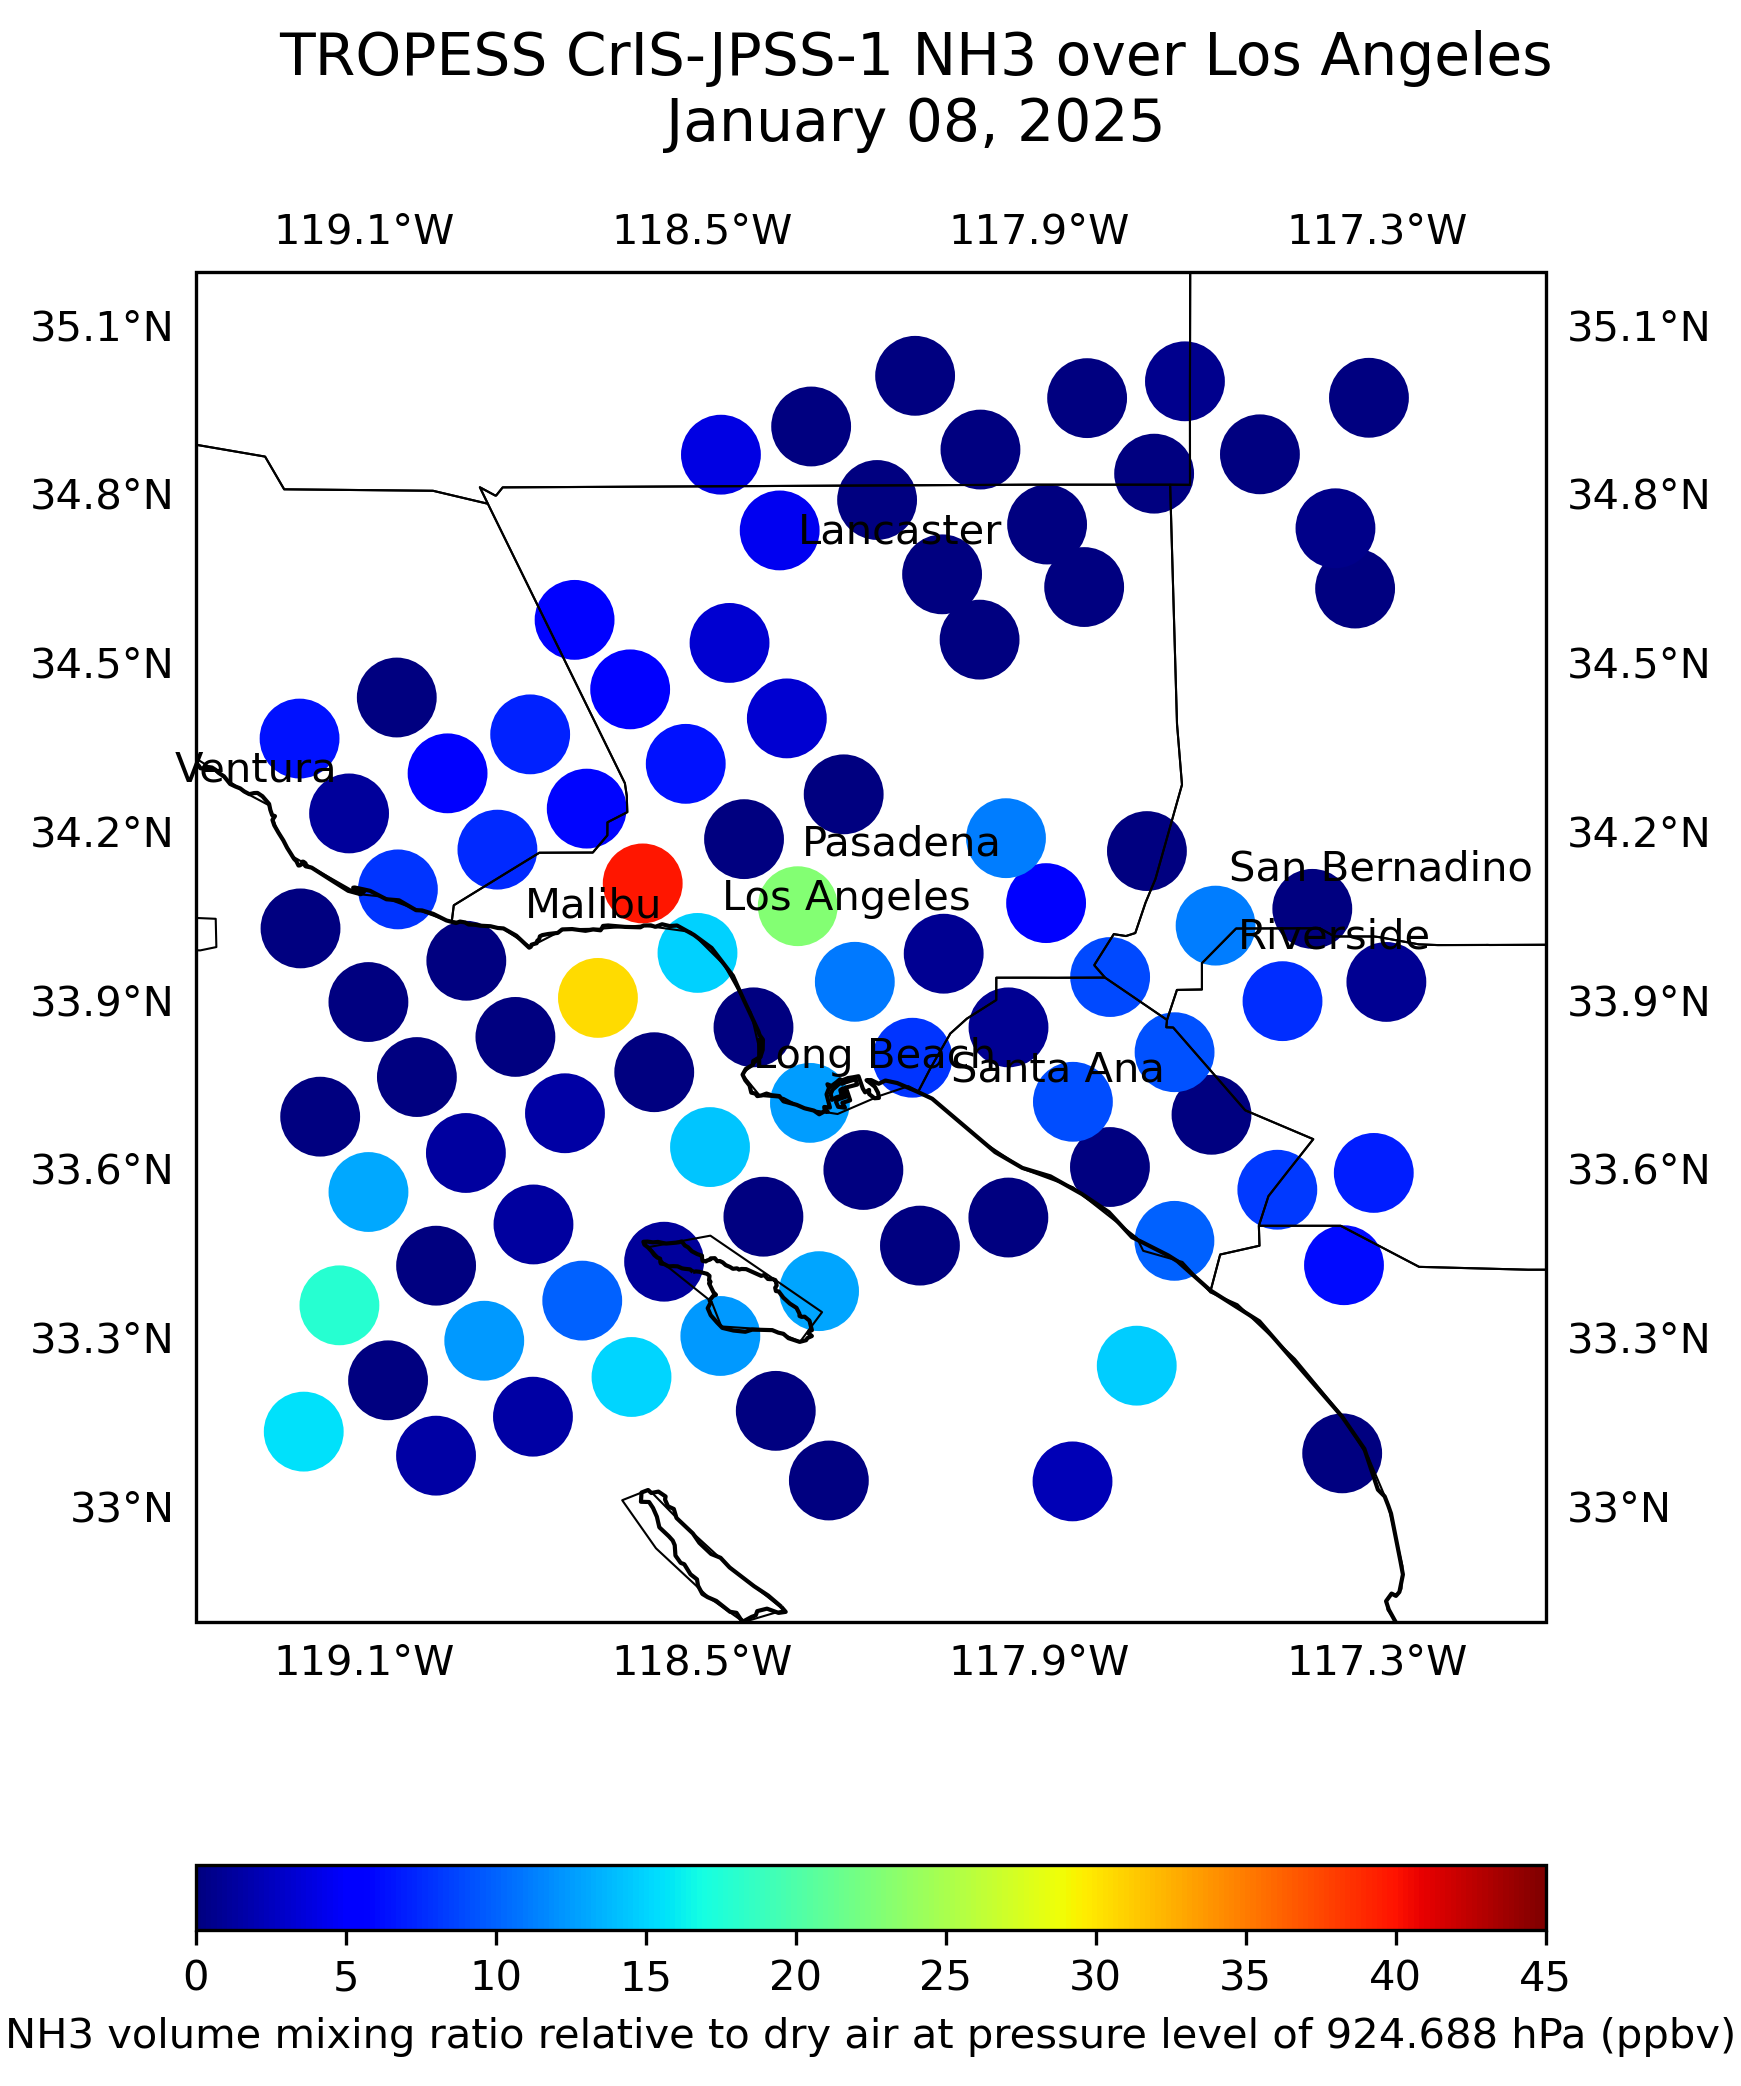

min value: 0.03292592614889145, max value: 47.04353713989258


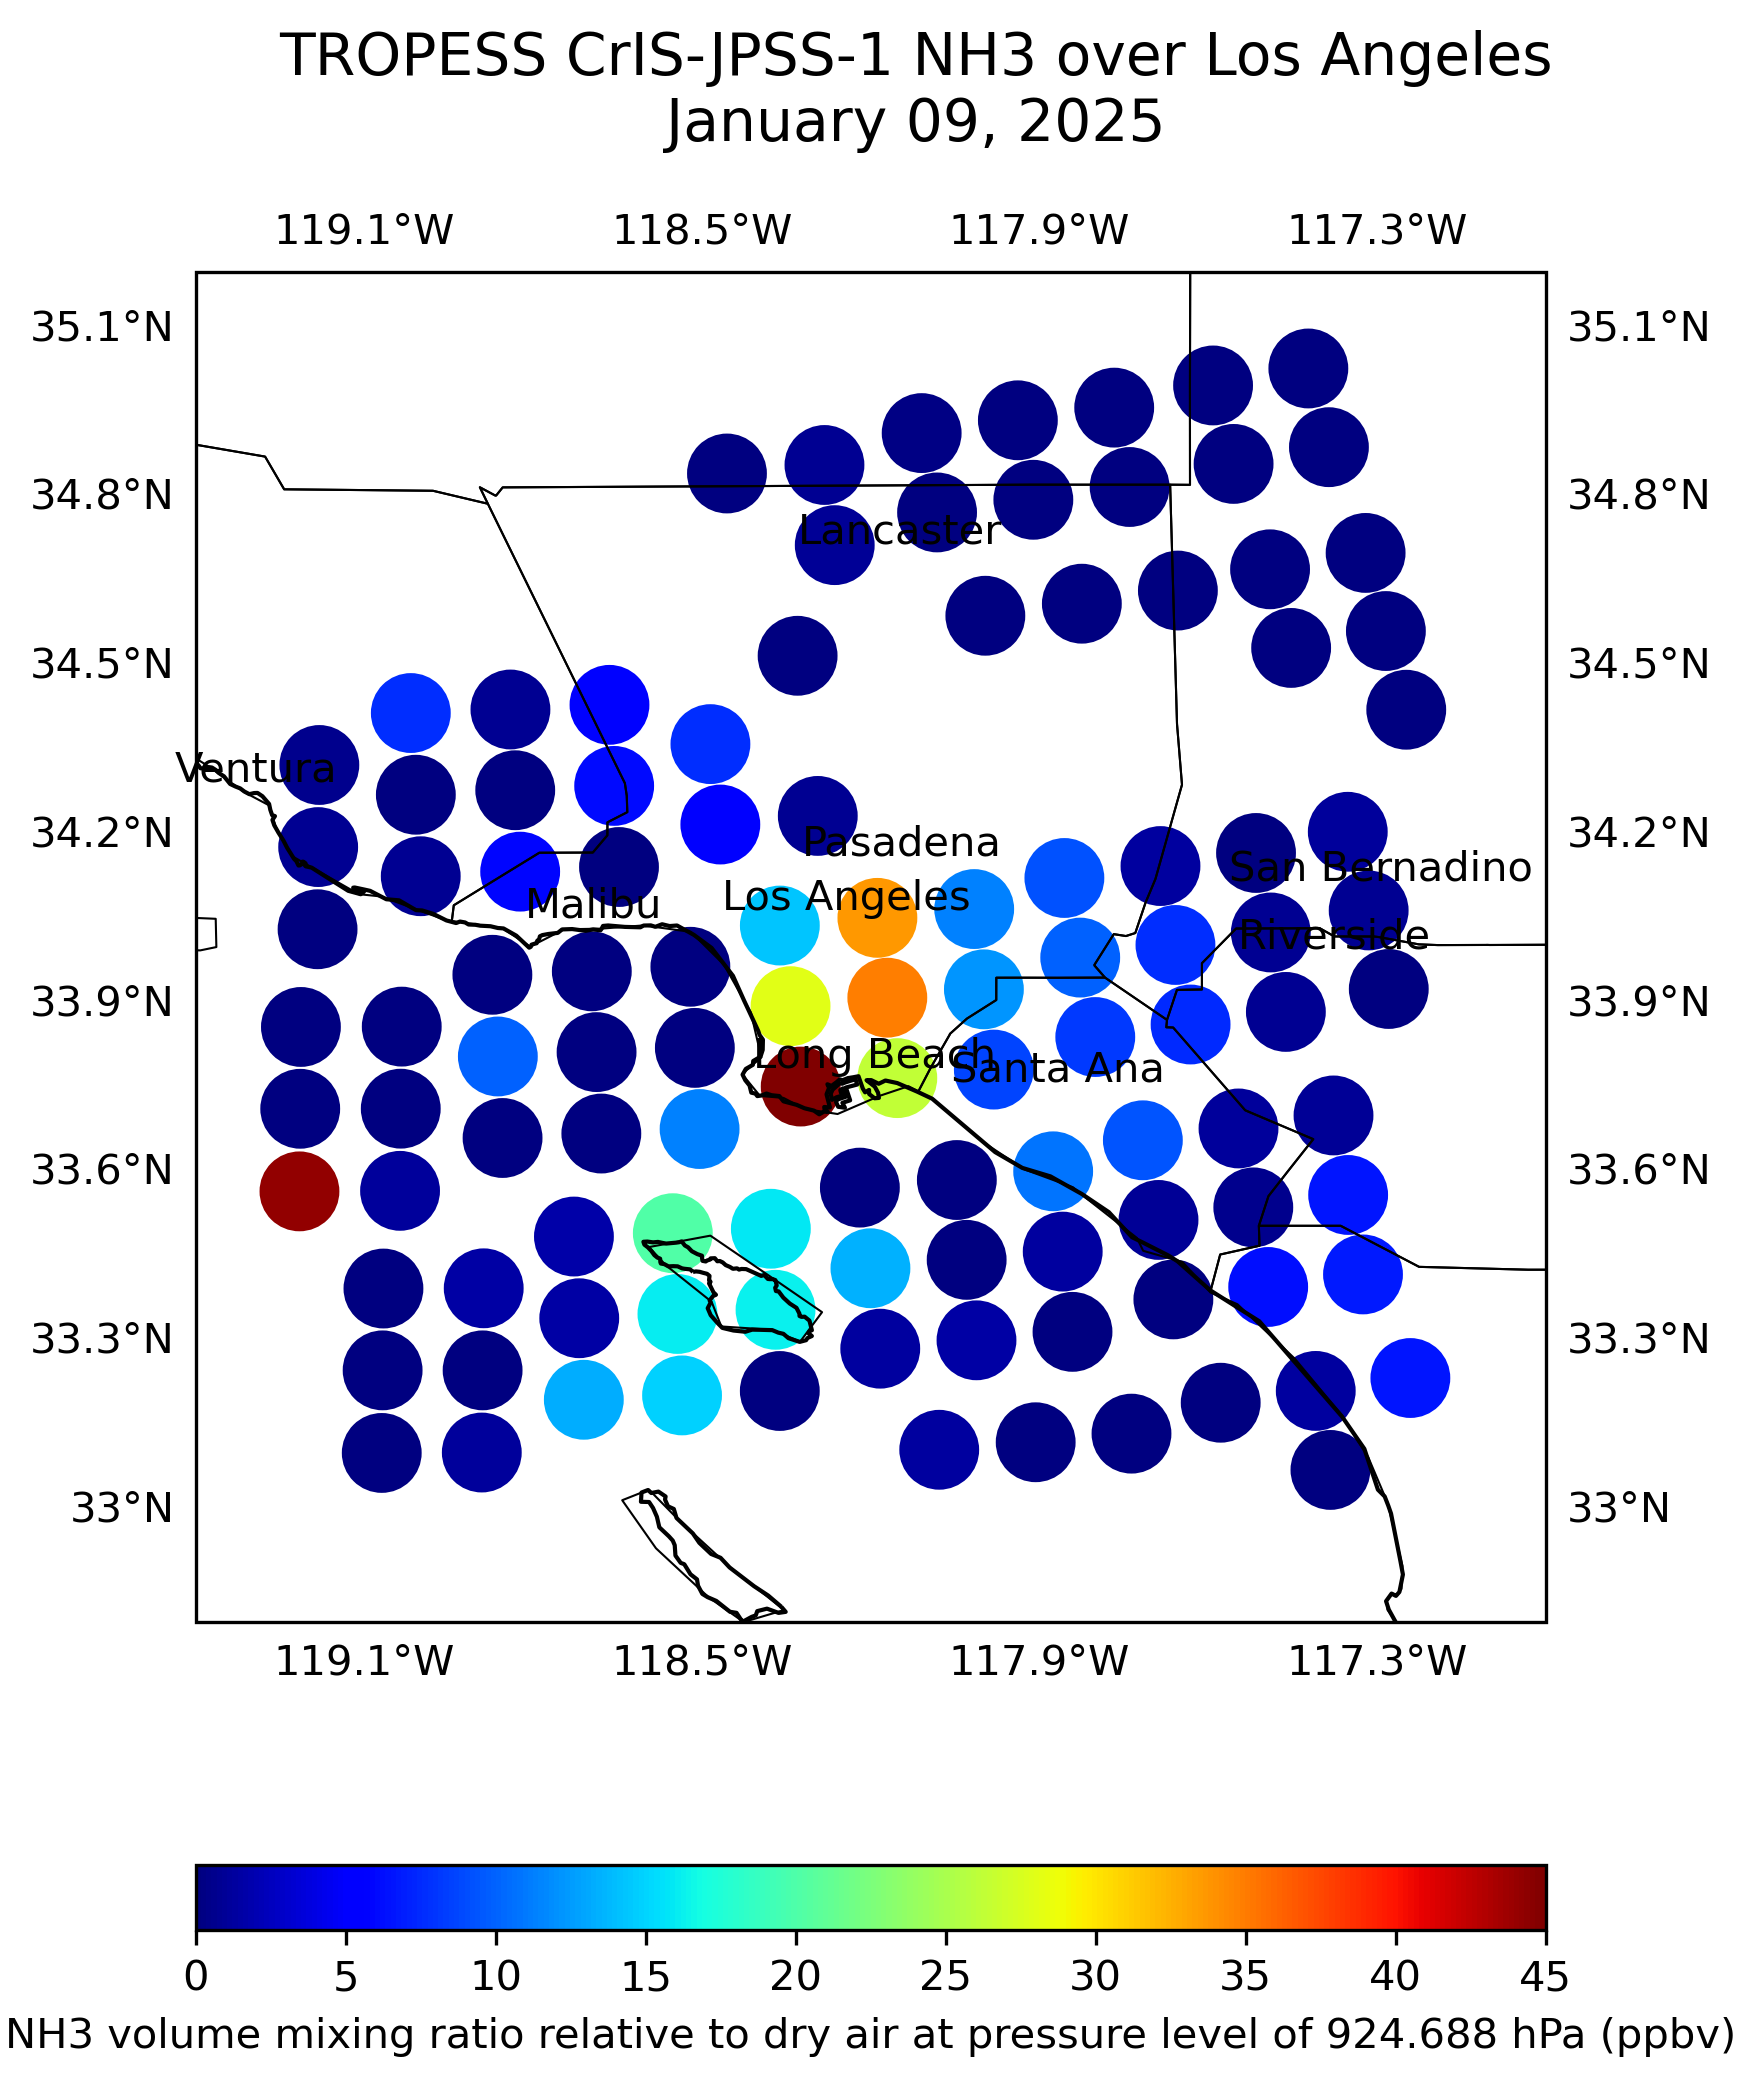

min value: 0.03391556069254875, max value: 15.256407737731934


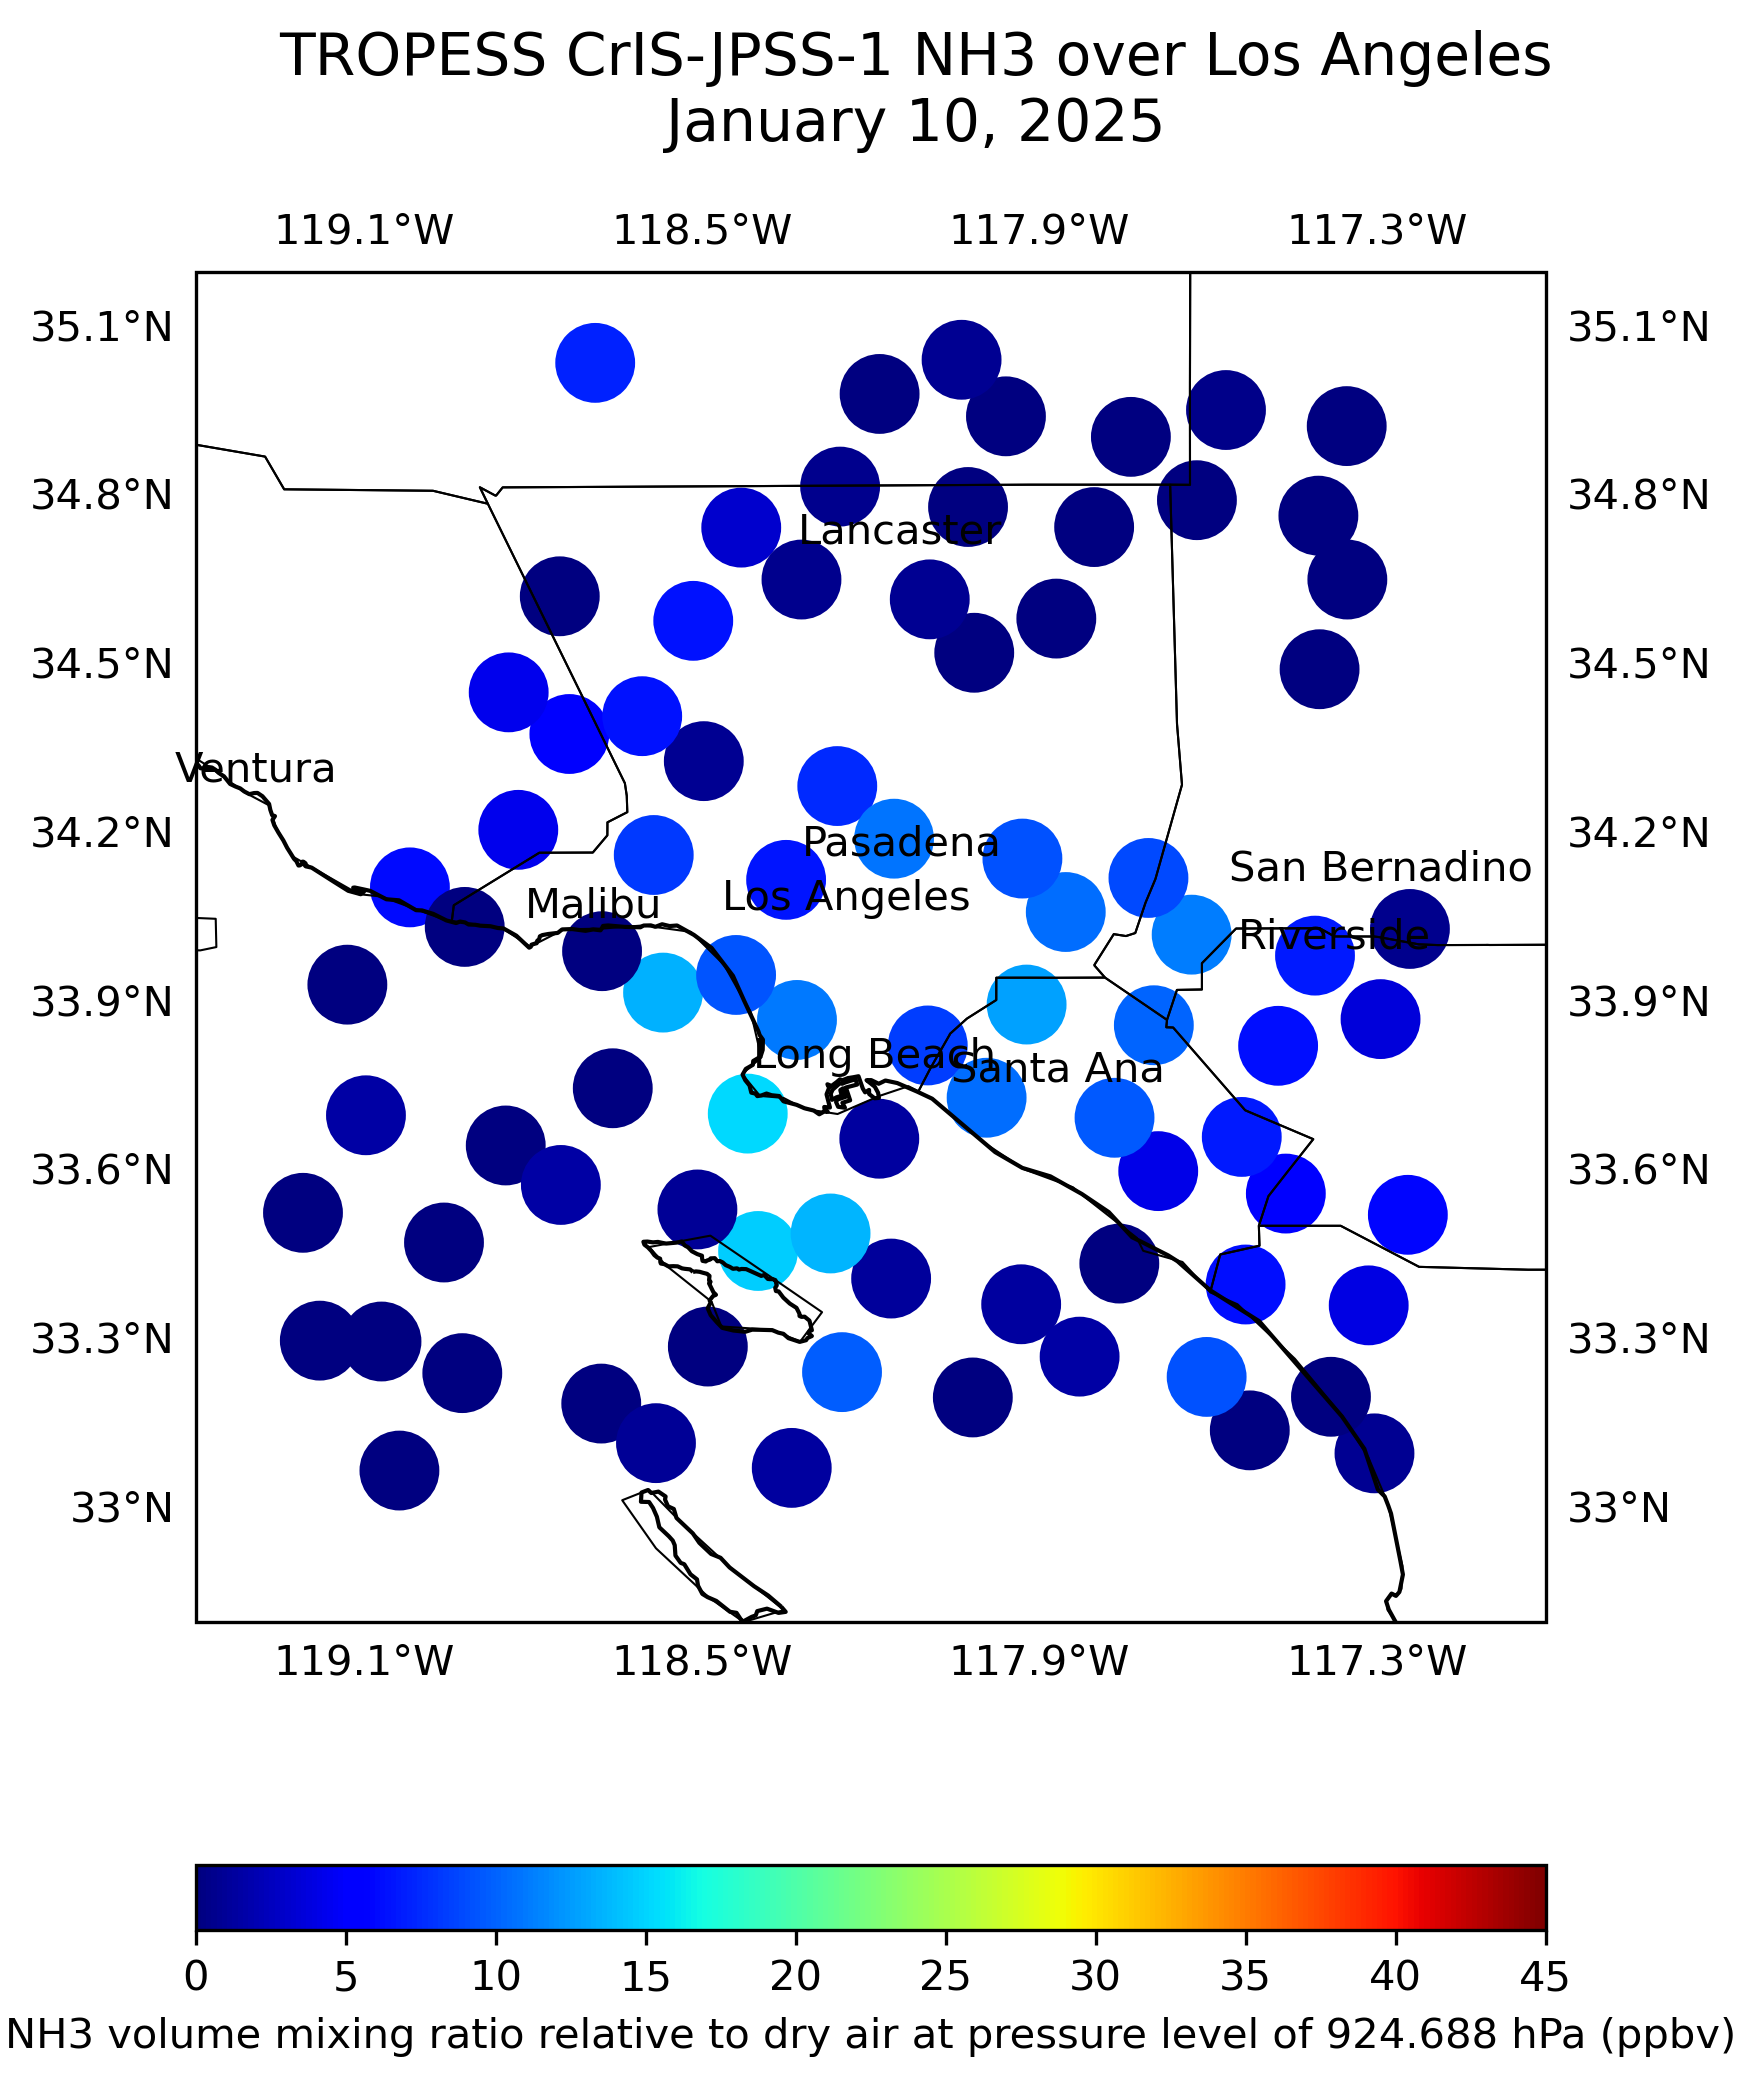

In [18]:
vmin = 0.0
vmax = 45

filename = DOWNLOAD_DIRECTORY + '/TROPESS_CrIS-JPSS1_L2_Standard_NH3_20250107_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc'
ds = xr.open_dataset(filename)
ds_aux = xr.open_dataset(filename, group='geophysical')
latitude, longitude, this_data = filter_good_col_data(ds, ds_aux, 'NH3')
data_label = 'NH3 volume mixing ratio relative to dry air at pressure level of 924.688 hPa (ppbv)'
figure_title = 'TROPESS CrIS-JPSS-1 NH3 over Los Angeles\nJanuary 07, 2025'
image_filename = PLOT_DIRECTORY + '/NH3_Filtered_20250107.png'
plot_data_map(latitude, longitude, this_data, vmin, vmax, data_label, figure_title, image_filename)

filename = DOWNLOAD_DIRECTORY + '/TROPESS_CrIS-JPSS1_L2_Standard_NH3_20250108_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc'
ds = xr.open_dataset(filename)
ds_aux = xr.open_dataset(filename, group='geophysical')
latitude, longitude, this_data = filter_good_col_data(ds, ds_aux, 'NH3')
data_label = 'NH3 volume mixing ratio relative to dry air at pressure level of 924.688 hPa (ppbv)'
figure_title = 'TROPESS CrIS-JPSS-1 NH3 over Los Angeles\nJanuary 08, 2025'
image_filename = PLOT_DIRECTORY + '/NH3_Filtered_20250108.png'
plot_data_map(latitude, longitude, this_data, vmin, vmax, data_label, figure_title, image_filename)

filename = DOWNLOAD_DIRECTORY + '/TROPESS_CrIS-JPSS1_L2_Standard_NH3_20250109_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc'
ds = xr.open_dataset(filename)
ds_aux = xr.open_dataset(filename, group='geophysical')
latitude, longitude, this_data = filter_good_col_data(ds, ds_aux, 'NH3')
data_label = 'NH3 volume mixing ratio relative to dry air at pressure level of 924.688 hPa (ppbv)'
figure_title = 'TROPESS CrIS-JPSS-1 NH3 over Los Angeles\nJanuary 09, 2025'
image_filename = PLOT_DIRECTORY + '/NH3_Filtered_20250109.png'
plot_data_map(latitude, longitude, this_data, vmin, vmax, data_label, figure_title, image_filename)

filename = DOWNLOAD_DIRECTORY + '/TROPESS_CrIS-JPSS1_L2_Standard_NH3_20250110_MUSES_R1p23_SC_MGLOS_F2p9_J0.nc'
ds = xr.open_dataset(filename)
ds_aux = xr.open_dataset(filename, group='geophysical')
latitude, longitude, this_data = filter_good_col_data(ds, ds_aux, 'NH3')
data_label = 'NH3 volume mixing ratio relative to dry air at pressure level of 924.688 hPa (ppbv)'
figure_title = 'TROPESS CrIS-JPSS-1 NH3 over Los Angeles\nJanuary 10, 2025'
image_filename = PLOT_DIRECTORY + '/NH3_Filtered_20250110.png'
plot_data_map(latitude, longitude, this_data, vmin, vmax, data_label, figure_title, image_filename)

## Make GIF movie files out of the daily image files. 

In [22]:
image_files = []
image_files.append(PLOT_DIRECTORY + '/CO_Filtered_20250107.png')
image_files.append(PLOT_DIRECTORY + '/CO_Filtered_20250108.png')
image_files.append(PLOT_DIRECTORY + '/CO_Filtered_20250109.png')
image_files.append(PLOT_DIRECTORY + '/CO_Filtered_20250110.png')

# Output movie filename
output_movie = PLOT_DIRECTORY + '/CO_filtered.gif'

# Read the images and add to a list
#with contextlib.redirect_stdout(None):
images = []
for filename in image_files:
        image = imageio.imread(filename)
        #print(f"File: {filename}, Shape: {image.shape}")
        images.append(image)
# Save the images as an animated gif
# duration is the time spent on each image (in milliseconds)
imageio.mimsave(output_movie, images, duration=1000.0, loop=0) 

print(f"Movie saved as {output_movie}")

Movie saved as ./plot/CO_filtered.gif


In [23]:
image_files = []
image_files.append(PLOT_DIRECTORY + '/PAN_Filtered_20250107.png')
image_files.append(PLOT_DIRECTORY + '/PAN_Filtered_20250108.png')
image_files.append(PLOT_DIRECTORY + '/PAN_Filtered_20250109.png')
image_files.append(PLOT_DIRECTORY + '/PAN_Filtered_20250110.png')

# Output movie filename
output_movie = PLOT_DIRECTORY + '/PAN_filtered.gif'

# Read the images and add to a list
#with contextlib.redirect_stdout(None):
images = []
for filename in image_files:
        image = imageio.imread(filename)
        #print(f"File: {filename}, Shape: {image.shape}")
        images.append(image)
# Save the images as an animated gif
# duration is the time spent on each image (in milliseconds)
imageio.mimsave(output_movie, images, duration=1000.0, loop=0) 

print(f"Movie saved as {output_movie}")

Movie saved as ./plot/PAN_filtered.gif


In [24]:
image_files = []
image_files.append(PLOT_DIRECTORY + '/NH3_Filtered_20250107.png')
image_files.append(PLOT_DIRECTORY + '/NH3_Filtered_20250108.png')
image_files.append(PLOT_DIRECTORY + '/NH3_Filtered_20250109.png')
image_files.append(PLOT_DIRECTORY + '/NH3_Filtered_20250110.png')

# Output movie filename
output_movie = PLOT_DIRECTORY + '/NH3_filtered.gif'

# Read the images and add to a list
#with contextlib.redirect_stdout(None):
images = []
for filename in image_files:
        image = imageio.imread(filename)
        #print(f"File: {filename}, Shape: {image.shape}")
        images.append(image)
# Save the images as an animated gif
# duration is the time spent on each image (in milliseconds)
imageio.mimsave(output_movie, images, duration=1000.0, loop=0) 

print(f"Movie saved as {output_movie}")

Movie saved as ./plot/NH3_filtered.gif


## Export this notebook to HTML for sharing

In [25]:
cmd = "jupyter nbconvert --to html 'plot_LA_Fires_Trace_Gas_Outflow.ipynb'"
os.popen(cmd)

[NbConvertApp] Converting notebook plot_LA_Fires_Trace_Gas_Outflow.ipynb to html
[NbConvertApp] Writing 7049240 bytes to plot_LA_Fires_Trace_Gas_Outflow.html
